In [1]:
import os
import re
import io
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score


import matplotlib.pyplot as plt
import seaborn as sns
# 设置matplotlib参数
plt.style.use('default')  # 使用默认样式

# 尝试设置中文字体支持(如果失败则使用默认字体)
try:
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("注意: 中文字体设置失败,将使用默认字体")
    pass

In [2]:
def parse_filename(filename) -> dict:
    # 去掉扩展名
    name = filename.rsplit('.', 1)[0]
    parts = name.split('_')
    if len(parts) < 6:
        print(f"文件名格式无效: {filename}")
        return {}
    return {
        'collection_mode': parts[0],
        'label': parts[1],
        'tester': parts[2],
        'date': parts[3],
        'time': parts[4],
        'mac': parts[5],
        'name': name
    }

In [3]:
class WearLogParser:
    def __init__(self):
        # 建立简写到完整变量名的映射表(基于你提供的C代码)
        self.field_map = {
            "wf": "wear_flag",
            "en": "error_no",
            "rt": "return_type",
            "ir": "wear_ir_result",
            "gr": "wear_green_result",
            "amb": "wear_ambient_result",
            "cf": "confusion",
            "pk": "peak_cnt",
            "hr": "wear_rr_hr",
            "dc": "ppg_dc_value",
            "gtf": "green_temp_flag_encode",
            "acm": "wear_acc_momentum",
            "as": "amb_std",
            "it": "init_timer",
            "st": "state",
            "6d": "imu_6d_state",
            "gc": "ppg_g_current",
            "gi": "ppg_g_idac",
            "irv": "ppg_ir_value",
            "eg": "entropy_geometric",
            # "ep": "entropy_permutation",
            "zcr": "zero_crossing_rate",
            # "amp": "ac_amplitude",
            # "std": "std"
        }

    def parse_line(self, log_line):
        """解析单行日志"""
        # 1. 提取有效数据部分 (去除时间戳或前缀 [wear_check_algo]->)
        if "[wear_check_algo]->wf=" in log_line:
            _, content = log_line.split("[wear_check_algo]->", 1)
        else:
            # 如果找不到前缀,尝试直接解析整行,或者根据情况调整
            return {}
            content = log_line

        # 2. 正则匹配 key=value 格式
        # pattern 解释: 找到所有 字母数字组合=非空字符
        matches = re.findall(r'(\w+)=([^\s]+)', content)
        
        result = {}
        for key, value in matches:
            # 获取完整字段名,如果未定义则使用原始key
            full_name = self.field_map.get(key, key)
            
            # 3. 数值转换 (自动处理 十进制 和 0x十六进制)
            try:
                # int(x, 0) 可以自动识别 123 和 0x1A
                clean_value = int(value, 0)
            except ValueError:
                clean_value = value # 如果转换失败,保留字符串
            
            result[full_name] = clean_value
            
        return result

In [12]:


# folder_path = r"G:\python\rawdata_Wearing\10_" 

folder_path = r"G:\python\rawdata_Wearing\BaseLine_YY"


def parse_filename(filename) -> dict:
    # 去掉扩展名
    name = filename.rsplit('.', 1)[0]
    parts = name.split('_')
    if len(parts) < 6:
        print(f"文件名格式无效: {filename}")
        return {}
    return {
        'collection_mode': parts[0],
        'label': parts[1],
        'tester': parts[2],
        'date': parts[3],
        'time': parts[4],
        'mac': parts[5],
        'name': name
    }



# # 正则1: 从文件名提取 MAC (例如 _8e26_log.txt -> 8e26)
# filename_mac_pattern = re.compile(r"_([0-9a-fA-F]{4})_log\.txt$")
# # 正则2: 从文件内容提取 median 值
# content_median_pattern = re.compile(r"IR value=(\d+)")


file_dict = {}
data_list = []
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if not filename.endswith(".txt"):
            continue
            
        # --- A. 提取 MAC ---
        info = parse_filename(filename)
        mac_addr = info.get('mac') 
        if not mac_addr:
            continue

        
        label = info.get('label')
        # --- B. 提取 Label (分类) ---
        if "Wearing" == label:
            label = 1 # Wearing
            status_str = "Wearing"
        elif "Unwear" == label:
            label = 0 # Unwear
            status_str = "Unwear"
        else:
            print(f"未知的标签 {label} 在文件 {filename} 中")
            continue # 跳过其他文件

        # --- C. 读取内容 ---
        file_path = os.path.join(root, filename)
        # file_list.append(file_path)
        name = info.get('name')
        file_dict[name] = []
        parser = WearLogParser()
        i = 0
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                        data = parser.parse_line(line)
                        if data:
                            i += 1
                            # 'Status', 'Label', 'Value', 'Filename'
                            data['MAC'] = mac_addr
                            data['Status'] = status_str
                            data['Label'] = label
                            data['Filename'] = filename
                    
                            # 收集原始数据
                            data_list.append(data)
                            file_dict[name].append(data)
            if (i == 0):
                print(f"文件 {file_path} 中未找到匹配的 median 数据")
        except Exception as e:
            print(f"读取文件 {file_path} 出错: {e}")

if not data_list:
    print("未找到有效数据,请检查路径。")

df = pd.DataFrame(data_list)

df_dict = {}
for name in file_dict:
    df_dict[name] = pd.DataFrame(file_dict[name]) 
print(f"原始数据共 {len(df)} 行,包含设备: {df['MAC'].unique()}")
print(f"{df_dict.keys()}")

原始数据共 9297 行,包含设备: ['d9e5' 'e61b' '0b99' '5d4d' '28d1' '8e26' '5ab5' 'd3fe' '9ec9' 'cbaf']
dict_keys(['Wear_Unwear_shb_20251219_175814_d9e5_log', 'Wear_Unwear_shb_20251219_175814_e61b_log', 'Wear_Unwear_shb_20251219_180223_d9e5_log', 'Wear_Unwear_shb_20251219_180223_e61b_log', 'Wear_Unwear_shb_20251219_180608_d9e5_log', 'Wear_Unwear_shb_20251219_180608_e61b_log', 'Wear_Unwear_shb_20251219_181041_d9e5_log', 'Wear_Unwear_shb_20251219_181041_e61b_log', 'Wear_Unwear_shb_20251219_183336_0b99_log', 'Wear_Unwear_shb_20251219_183336_5d4d_log', 'Wear_Unwear_shb_20251219_183727_0b99_log', 'Wear_Unwear_shb_20251219_183727_5d4d_log', 'Wear_Unwear_shb_20251219_184113_0b99_log', 'Wear_Unwear_shb_20251219_184113_5d4d_log', 'Wear_Unwear_shb_20251219_184449_0b99_log', 'Wear_Unwear_shb_20251219_184449_5d4d_log', 'Wear_Unwear_wsf_20251219_173536_28d1_log', 'Wear_Unwear_wsf_20251219_173536_8e26_log', 'Wear_Unwear_wsf_20251219_173906_28d1_log', 'Wear_Unwear_wsf_20251219_173906_8e26_log', 'Wear_Unwear_wsf_2

In [13]:
df_ir_info = df[df['ppg_ir_value'] != 0].groupby('Filename').agg({'ppg_ir_value': 'mean', 'MAC': 'first'})
df_ir_info

ppg_ir_value   MAC
Filename                                                         
Wear_Unwear_shb_20251219_175814_d9e5_log.txt    1554.666667  d9e5
Wear_Unwear_shb_20251219_175814_e61b_log.txt    2290.829060  e61b
Wear_Unwear_shb_20251219_180223_d9e5_log.txt    1846.923077  d9e5
Wear_Unwear_shb_20251219_180223_e61b_log.txt    2881.867769  e61b
Wear_Unwear_shb_20251219_180608_d9e5_log.txt    1910.676471  d9e5
Wear_Unwear_shb_20251219_180608_e61b_log.txt    2946.107914  e61b
Wear_Unwear_shb_20251219_181041_d9e5_log.txt    2831.527778  d9e5
Wear_Unwear_shb_20251219_181041_e61b_log.txt    3780.725664  e61b
Wear_Unwear_shb_20251219_183336_0b99_log.txt    1434.245902  0b99
Wear_Unwear_shb_20251219_183336_5d4d_log.txt    1230.924051  5d4d
Wear_Unwear_shb_20251219_183727_0b99_log.txt    1808.030534  0b99
Wear_Unwear_shb_20251219_183727_5d4d_log.txt    1585.000000  5d4d
Wear_Unwear_shb_20251219_184113_0b99_log.txt    1862.328244  0b99
Wear_Unwear_shb_20251219_184113_5d4d_log.txt    1819.833333  5d4d
Wear_Unwear_shb_20251219_184449_0b99_log.txt    2977.525180  0b99
Wear_Unwear_shb_20251219_184449_5d4d_log.txt    2629.460000  5d4d
Wear_Unwear_wsf_20251219_173536_28d1_log.txt     952.913043  28d1
Wear_Unwear_wsf_20251219_173536_8e26_log.txt    1354.948718  8e26
Wear_Unwear_wsf_20251219_173906_28d1_log.txt    1258.201754  28d1
Wear_Unwear_wsf_20251219_173906_8e26_log.txt    1757.321739  8e26
Wear_Unwear_wsf_20251219_174246_28d1_log.txt    1385.485981  28d1
Wear_Unwear_wsf_20251219_174246_8e26_log.txt    1665.101695  8e26
Wear_Unwear_wsf_20251219_174612_28d1_log.txt    1830.747967  28d1
Wear_Unwear_wsf_20251219_174612_8e26_log.txt    2300.444444  8e26
Wear_Unwear_wsf_20251219_175846_5ab5_log.txt     313.157895  5ab5
Wear_Unwear_wsf_20251219_175846_d3fe_log.txt     375.394737  d3fe
Wear_Unwear_wsf_20251219_180225_5ab5_log.txt     615.534483  5ab5
Wear_Unwear_wsf_20251219_180225_d3fe_log.txt     749.741071  d3fe
Wear_Unwear_wsf_20251219_180720_5ab5_log.txt     698.336283  5ab5
Wear_Unwear_wsf_20251219_180720_d3fe_log.txt     841.140351  d3fe
Wear_Unwear_wsf_20251219_181040_5ab5_log.txt    1849.391667  5ab5
Wear_Unwear_wsf_20251219_181040_d3fe_log.txt    2110.942623  d3fe
Wear_Unwear_wsf_20251219_183338_9ec9_log.txt    1121.869919  9ec9
Wear_Unwear_wsf_20251219_183338_cbaf_log.txt    1609.909091  cbaf
Wear_Unwear_wsf_20251219_183727_9ec9_log.txt    1446.489362  9ec9
Wear_Unwear_wsf_20251219_183728_cbaf_log.txt    1972.957447  cbaf
Wear_Unwear_wsf_20251219_184114_9ec9_log.txt    1542.816176  9ec9
Wear_Unwear_wsf_20251219_184114_cbaf_log.txt    2030.614815  cbaf
Wear_Unwear_wsf_20251219_184451_9ec9_log.txt    2512.062937  9ec9
Wear_Unwear_wsf_20251219_184451_cbaf_log.txt    2759.063830  cbaf
Wear_Wearing_shb_20251219_181416_d9e5_log.txt   4104.446281  d9e5
Wear_Wearing_shb_20251219_181416_e61b_log.txt   5192.182540  e61b
Wear_Wearing_shb_20251219_184934_0b99_log.txt   4213.024000  0b99
Wear_Wearing_shb_20251219_184934_5d4d_log.txt   4026.512195  5d4d
Wear_Wearing_wsf_20251219_174955_28d1_log.txt   3881.646018  28d1
Wear_Wearing_wsf_20251219_174955_8e26_log.txt   4040.239316  8e26
Wear_Wearing_wsf_20251219_181416_5ab5_log.txt   2464.584746  5ab5
Wear_Wearing_wsf_20251219_181416_d3fe_log.txt   3768.596774  d3fe
Wear_Wearing_wsf_20251219_184934_9ec9_log.txt   3174.971429  9ec9
Wear_Wearing_wsf_20251219_184934_cbaf_log.txt   4081.750000  cbaf

In [14]:

df_ir = df[df['ppg_ir_value'] != 0].reset_index(drop=True)
unwear_ir_df = df_ir[df_ir['Label'] == 0].groupby('Filename').agg({'ppg_ir_value': 'mean', 'MAC': 'first'})
wear_ir_df = df_ir[df_ir['Label'] == 1].groupby('Filename').agg({'ppg_ir_value': 'mean', 'MAC': 'first'})


基准值 (Unwear Baselines):{'0b99': 1434.2459016393443, '28d1': 952.9130434782609, '5ab5': 313.1578947368421, '5d4d': 1230.9240506329113, '8e26': 1354.948717948718, '9ec9': 1121.8699186991869, 'cbaf': 1609.909090909091, 'd3fe': 375.39473684210526, 'd9e5': 1554.6666666666667, 'e61b': 2290.82905982906}
MAC
0b99    0.340431
28d1    0.245492
5ab5    0.127063
5d4d    0.305705
8e26    0.335363
9ec9    0.353348
cbaf    0.394416
d3fe    0.099611
d9e5    0.378776
e61b    0.441207
Name: ppg_ir_value, dtype: float64

模型准确率: 100.00%

--- 深度决策树规则 (Depth=1) ---
|--- IR_Diff <= 1957.37
|   |--- class: 0
|--- IR_Diff >  1957.37
|   |--- class: 1



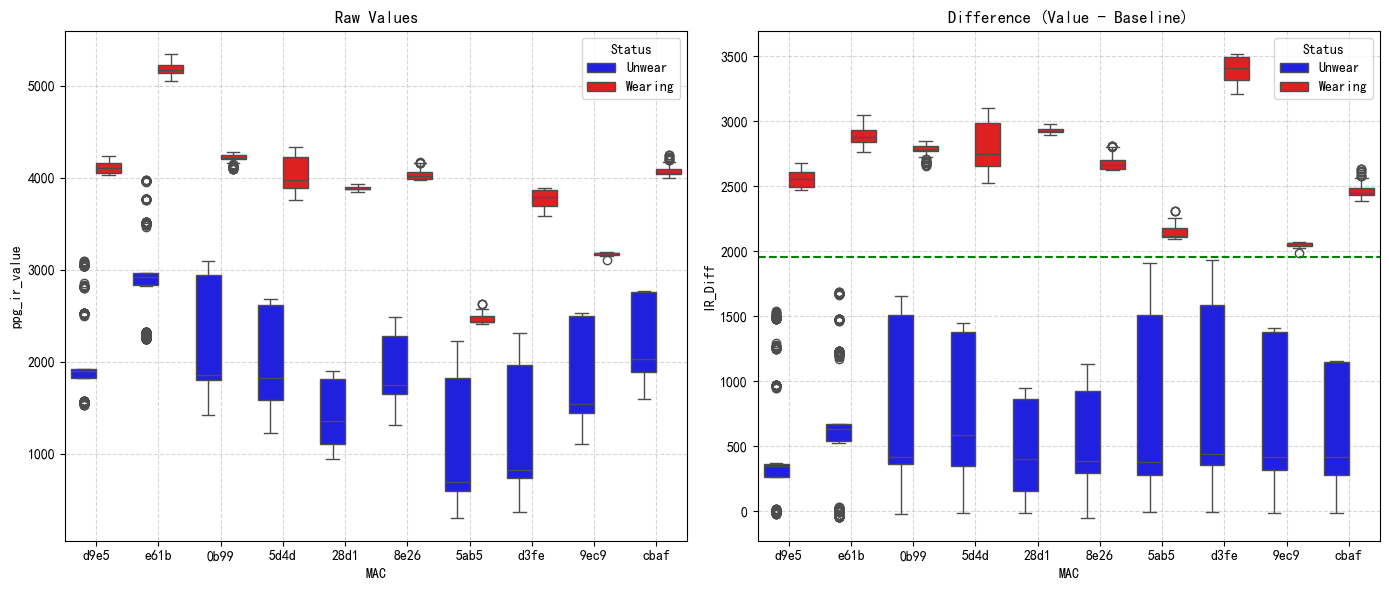

In [22]:



mac_baselines = unwear_ir_df.groupby('MAC')['ppg_ir_value'].min()
mac_wearing = wear_ir_df.groupby('MAC')['ppg_ir_value'].mean()
print(f"基准值 (Unwear Baselines):{mac_baselines.to_dict()}")


print(mac_baselines/mac_wearing)

valid_macs = mac_baselines.index.tolist()

df_clean = df_ir[df_ir['MAC'].isin(valid_macs) & (df_ir['ppg_ir_value'] != 0)].copy()
df_clean['Baseline'] = df_clean['MAC'].map(mac_baselines)

# ==========================================
# 4. 计算比值 (Ratio)
# ==========================================
# Ratio = 当前值 / 该设备的基准值
# 这里假设黑箱漏光为 0。如果有漏光数据,公式应为 (Val - Black) / (Base - Black)
df_clean['IR_Ratio'] = df_clean['ppg_ir_value'] / df_clean['Baseline']
# df_clean['Ratio']
df_clean['IR_Diff'] = df_clean['ppg_ir_value'] - df_clean['Baseline']

# ==========================================
# 2. 训练更深的决策树 (Depth = 1)
# ==========================================
# 特征 X 现在包含两列: IR_Diff 和 ppg_ir_value
param = ['IR_Diff']
X = df_clean[param]
y = df_clean['Label']

# max_depth=3: 允许模型进行最多 1 层判断 (也就是嵌套 3 层 if-else)
clf = DecisionTreeClassifier(max_depth=1, random_state=42)
clf.fit(X, y)

accuracy = clf.score(X, y)
print(f"\n模型准确率: {accuracy*100:.2f}%")

# ==========================================
# 3. 输出规则文本
# ==========================================
print("\n--- 深度决策树规则 (Depth=1) ---")
# feature_names 顺序必须和 X 的列顺序一致
r = export_text(clf, feature_names=param)
print(r)
threshold = clf.tree_.threshold[0]

plt.figure(figsize=(14, 6))

# 左图：原始值 (参差不齐)
plt.subplot(1, 2, 1)
sns.boxplot(data=df_clean, x='MAC', y='ppg_ir_value', hue='Status', palette={'Unwear': 'blue', 'Wearing': 'red'})
plt.title('Raw Values')
plt.grid(True, linestyle='--', alpha=0.5)

# 右图：差值 (看看红色箱子是否在同一水平线上)
plt.subplot(1, 2, 2)
sns.boxplot(data=df_clean, x='MAC', y='IR_Diff', hue='Status', palette={'Unwear': 'blue', 'Wearing': 'red'})
plt.title('Difference (Value - Baseline)')
# 画一条参考线,看看有没有一个通用的差值阈值
plt.axhline(y=threshold, color='green', linestyle='--', label='Hypothetical Threshold')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()




In [52]:
# ==========================================
# 通用的阈值测试函数
# ==========================================

def test_threshold_generic(df, threshold_value, feature_name, comparison='<='):
    """
    测试指定阈值的分类准确率(通用版本)
    
    参数:
        df: 数据集 DataFrame(必须包含 'Label' 和 'MAC' 列)
        threshold_value: 阈值
        feature_name: 特征名称
        comparison: 比较符号,'<=' 表示小于等于阈值为 Unwear(0),'>' 表示大于阈值为 Unwear(0)
    
    返回:
        accuracy: 准确率
        y_pred: 预测结果
    """
    X_test = df[feature_name]
    y_true = df['Label']
    
    # 根据阈值进行分类
    if comparison == '<=':
        # 小于等于阈值预测为 Unwear(0),大于阈值预测为 Wearing(1)
        y_pred = (X_test > threshold_value).astype(int)
    else:  # '>'
        # 大于阈值预测为 Unwear(0),小于等于阈值预测为 Wearing(1)
        y_pred = (X_test <= threshold_value).astype(int)
    
    # 计算准确率
    accuracy = accuracy_score(y_true, y_pred)
    
    # 计算混淆矩阵
    correct_unwear = ((y_true == 0) & (y_pred == 0)).sum()
    correct_wearing = ((y_true == 1) & (y_pred == 1)).sum()
    wrong_unwear = ((y_true == 0) & (y_pred == 1)).sum()
    wrong_wearing = ((y_true == 1) & (y_pred == 0)).sum()
    
    print(f"{'='*60}")
    print(f"阈值测试: {feature_name} {comparison} {threshold_value:.2f}")
    print(f"{'='*60}")
    print(f"总体准确率: {accuracy*100:.2f}%")
    print(f"\n分类详情:")
    print(f"  正确分类为 Unwear:  {correct_unwear} 个")
    print(f"  正确分类为 Wearing: {correct_wearing} 个")
    print(f"  误判为 Wearing:     {wrong_unwear} 个 (实际是 Unwear)")
    print(f"  误判为 Unwear:      {wrong_wearing} 个 (实际是 Wearing)")
    print(f"\n总样本数: {len(y_true)}")
    
    # 按设备分析(如果有 MAC 列)
    if 'MAC' in df.columns:
        print(f"\n按设备分析:")
        for mac in df['MAC'].unique():
            mac_mask = df['MAC'] == mac
            mac_acc = accuracy_score(y_true[mac_mask], y_pred[mac_mask])
            print(f"  {mac}: {mac_acc*100:.2f}%")
    
    return accuracy, y_pred


# ==========================================
# 使用示例 - IR 特征
# ==========================================
print("=" * 70)
print("IR 特征测试")
print("=" * 70)

# 测试阈值 2800
test_threshold_generic(df_clean, 2800, 'ppg_ir_value', '<=')
print("\n")

# 测试阈值 1800
test_threshold_generic(df_clean, 1800, 'IR_Diff', '<=')
print("\n")


# # ==========================================
# # 使用示例 - Green 特征
# # ==========================================
# print("=" * 70)
# print("Green 特征测试 (return_type == 12)")
# print("=" * 70)

# # 测试 entropy_geometric
# test_threshold_generic(green_df_12, 2.0, 'entropy_geometric', '<=')
# print("\n")

# # 测试 zero_crossing_rate
# test_threshold_generic(green_df_12, 0.3, 'zero_crossing_rate', '<=')
# print("\n")



IR 特征测试
阈值测试: ppg_ir_value <= 2800.00
总体准确率: 87.80%

分类详情:
  正确分类为 Unwear:  4115 个
  正确分类为 Wearing: 1002 个
  误判为 Wearing:     593 个 (实际是 Unwear)
  误判为 Unwear:      118 个 (实际是 Wearing)

总样本数: 5828

按设备分析:
  d9e5: 86.41%
  e61b: 39.45%
  0b99: 78.55%
  5d4d: 100.00%
  28d1: 100.00%
  8e26: 100.00%
  5ab5: 79.69%
  d3fe: 100.00%
  9ec9: 100.00%
  cbaf: 100.00%


阈值测试: IR_Diff <= 1800.00
总体准确率: 98.95%

分类详情:
  正确分类为 Unwear:  4647 个
  正确分类为 Wearing: 1120 个
  误判为 Wearing:     61 个 (实际是 Unwear)
  误判为 Unwear:      0 个 (实际是 Wearing)

总样本数: 5828

按设备分析:
  d9e5: 100.00%
  e61b: 100.00%
  0b99: 100.00%
  5d4d: 100.00%
  28d1: 100.00%
  8e26: 100.00%
  5ab5: 99.83%
  d3fe: 89.76%
  9ec9: 100.00%
  cbaf: 100.00%




In [36]:
# ppg_ir_value IR_Diff
X = df_clean[['ppg_ir_value']]
y = df_clean['Label']
groups = df_clean['MAC'] # 指定分组依据是 MAC

# 5折交叉验证(数据被分成5份,轮流做测试集)
gkf = GroupKFold(n_splits=5) 

print("=== 开始分组交叉验证 (Group K-Fold) ===")

fold = 1
scores = []
kappas = []

for train_idx, test_idx in gkf.split(X, y, groups):
    # 划分数据
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    # 训练
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_train, y_train)
    
    # 测试
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    scores.append(score)
    kappas.append(kappa)
    
    # 获取当前折的阈值
    threshold = clf.tree_.threshold[0]
    
    # 打印当前折的测试设备是哪些
    current_test_macs = groups.iloc[test_idx].unique()
    print(f"Fold {fold}: 准确率 = {score*100:.2f}% | Kappa = {kappa:.3f} | 阈值 = {threshold:.2f} | 测试设备: {current_test_macs}")
    
    fold += 1

print(f"\n平均准确率: {np.mean(scores)*100:.2f}%")
print(f"平均 Kappa: {np.mean(kappas):.3f}")

=== 开始分组交叉验证 (Group K-Fold) ===
Fold 1: 准确率 = 100.00% | Kappa = 1.000 | 阈值 = 3099.50 | 测试设备: ['0b99' '5d4d']
Fold 2: 准确率 = 90.49% | Kappa = 0.749 | 阈值 = 3099.50 | 测试设备: ['e61b' '28d1']
Fold 3: 准确率 = 90.13% | Kappa = 0.626 | 阈值 = 3099.50 | 测试设备: ['5ab5' 'cbaf']
Fold 4: 准确率 = 89.16% | Kappa = 0.452 | 阈值 = 3782.50 | 测试设备: ['d3fe' '9ec9']
Fold 5: 准确率 = 100.00% | Kappa = 1.000 | 阈值 = 3097.50 | 测试设备: ['d9e5' '8e26']

平均准确率: 93.96%
平均 Kappa: 0.765


In [37]:
valid_macs

['0b99',
 '28d1',
 '5ab5',
 '5d4d',
 '8e26',
 '9ec9',
 'cbaf',
 'd3fe',
 'd9e5',
 'e61b']

In [38]:
green_df_12 = df[df['return_type'] == 12][["ppg_dc_value" ,"ppg_g_current", "entropy_geometric",  "zero_crossing_rate", "MAC", "Status", "Label", "Filename"]].reset_index(drop=True)
green_df_12

ppg_dc_value  ppg_g_current  entropy_geometric  zero_crossing_rate  \
0             6971             22                 10                  38   
1             6971             22                 10                  40   
2             6971             22               9999                  40   
3             6971             22                174                  41   
4             6971             22                188                  45   
...            ...            ...                ...                 ...   
2500         38711              3                 58                   9   
2501         38486              3                 56                  10   
2502         38785              3                 58                  10   
2503         38600              3                 61                   9   
2504         38674              3                 71                  12   

       MAC   Status  Label                                       Filename  
0     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
1     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
2     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
3     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
4     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
...    ...      ...    ...                                            ...  
2500  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  
2501  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  
2502  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  
2503  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  
2504  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  

[2505 rows x 8 columns]

In [39]:
green_df_13 = df[df['return_type'] == 13][["ppg_dc_value" ,"ppg_g_current", "entropy_geometric",  "zero_crossing_rate", "MAC", "Status", "Label", "Filename"]].reset_index(drop=True)
green_df_13

ppg_dc_value  ppg_g_current  entropy_geometric  zero_crossing_rate  \
0             6021             90                 10                  37   
1             6021             90                177                  43   
2             6021             90                189                  42   
3             6021             90                211                  39   
4             6021             90                225                  39   
...            ...            ...                ...                 ...   
1214         39099             16                 22                  20   
1215         39759             16                 22                  22   
1216         40216             16                 21                  24   
1217         39529             16                 24                  18   
1218         39274             16                 23                  19   

       MAC   Status  Label                                       Filename  
0     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
1     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
2     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
3     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
4     d9e5   Unwear      0   Wear_Unwear_shb_20251219_175814_d9e5_log.txt  
...    ...      ...    ...                                            ...  
1214  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  
1215  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  
1216  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  
1217  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  
1218  cbaf  Wearing      1  Wear_Wearing_wsf_20251219_184934_cbaf_log.txt  

[1219 rows x 8 columns]

In [ ]:
# green_df_12

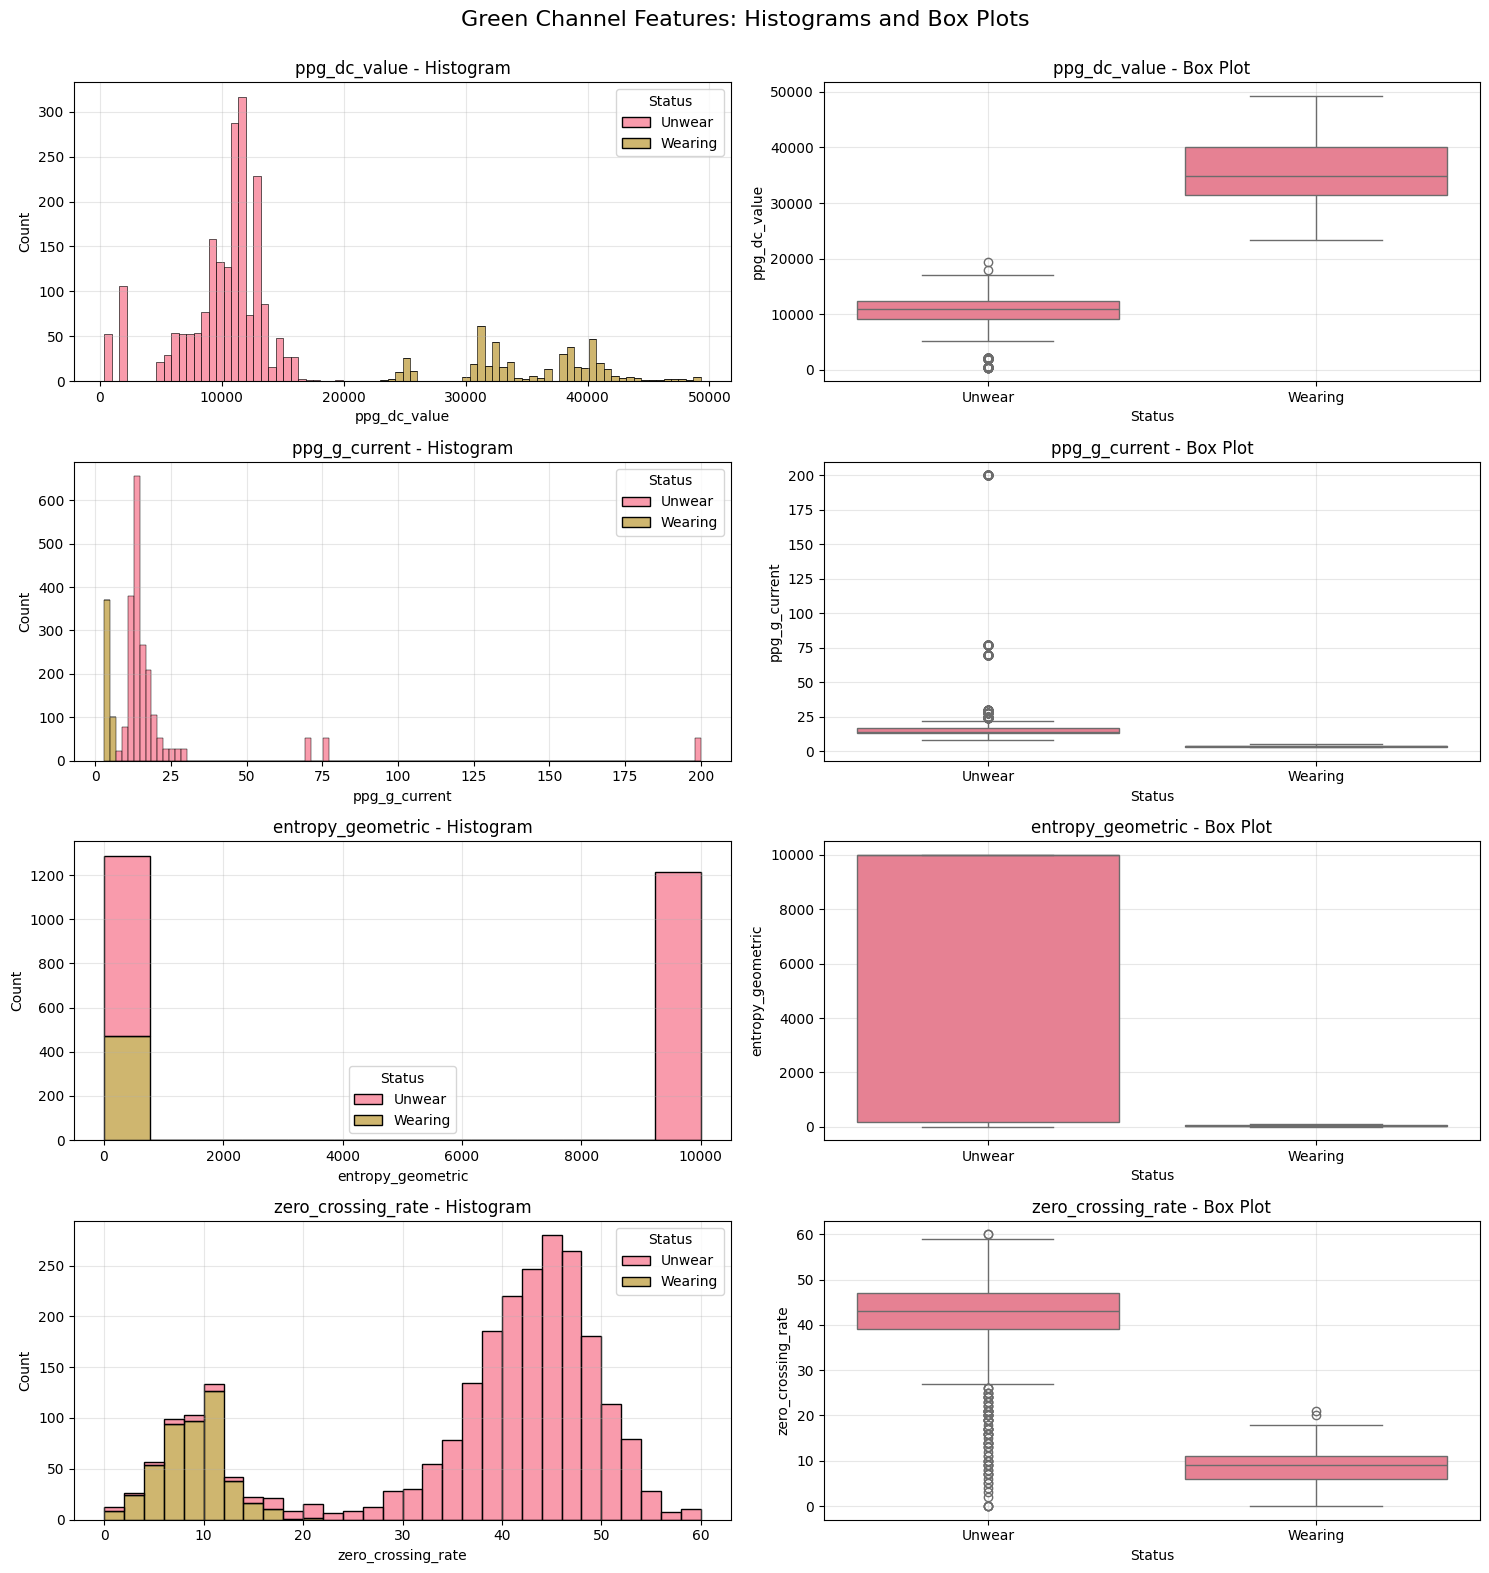

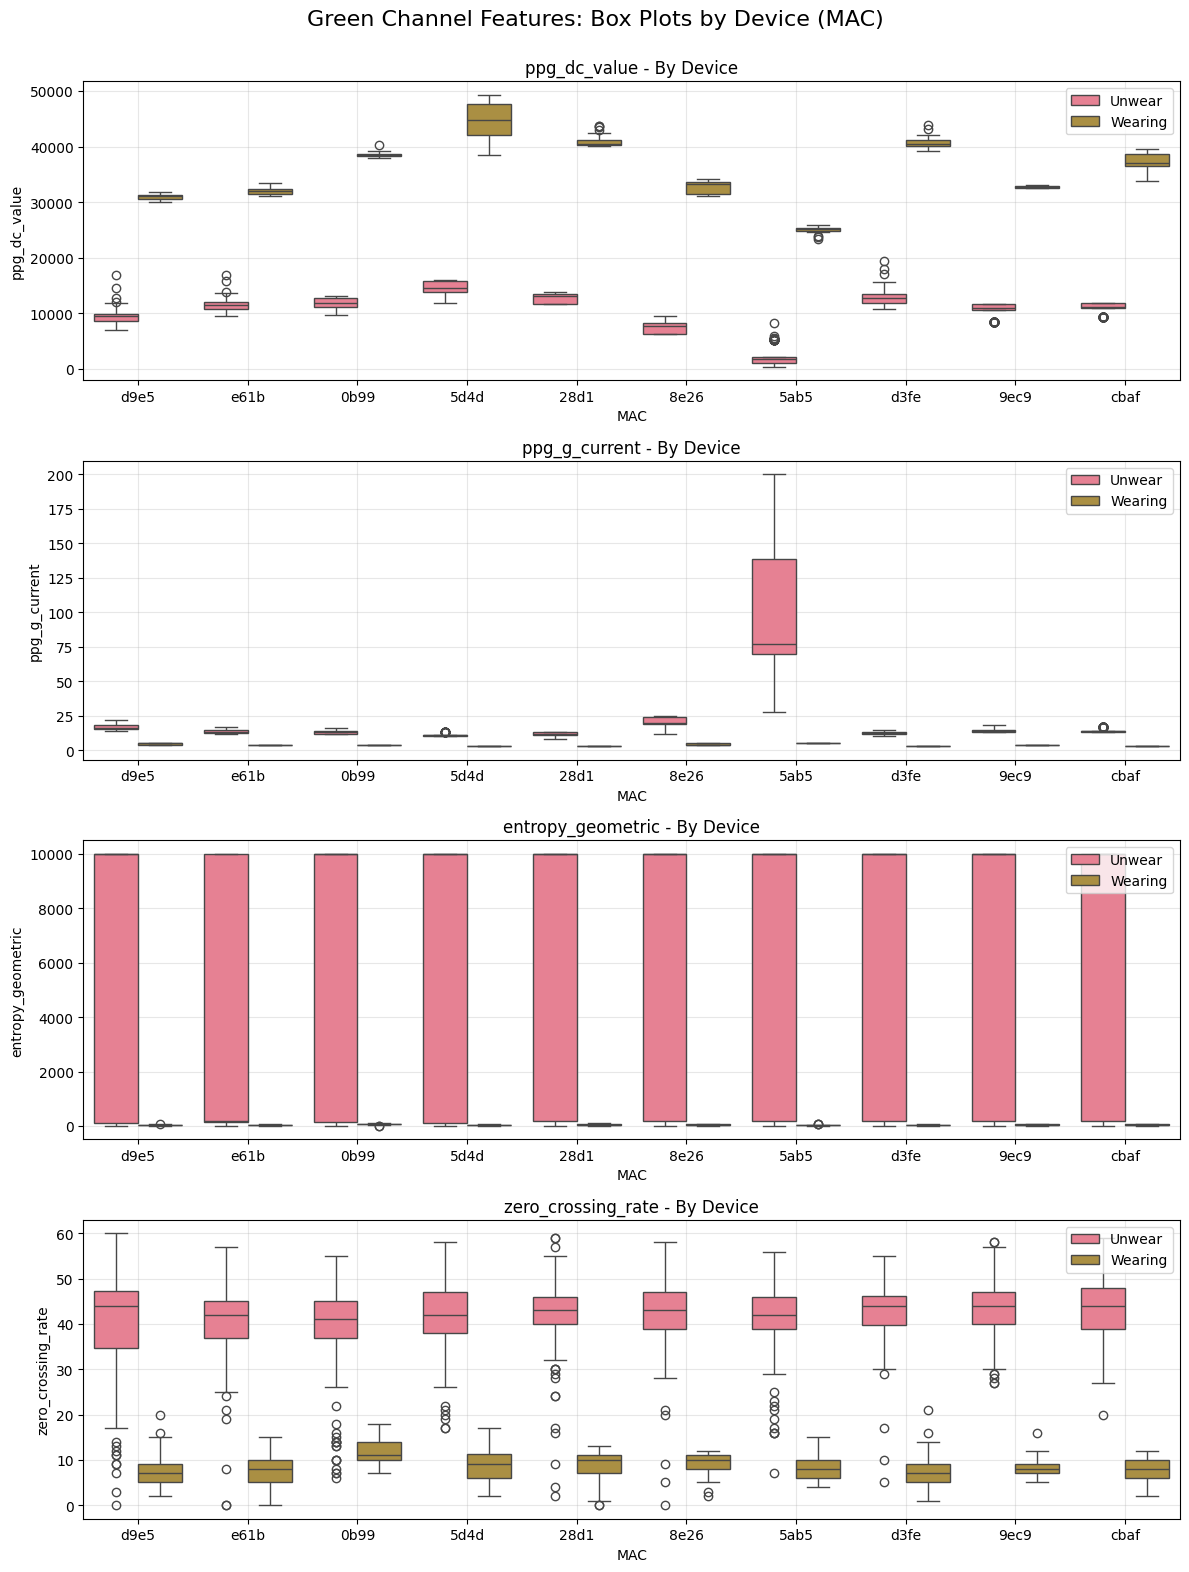

=== Green Channel 特征统计摘要 ===

ppg_dc_value:
          count          mean          std      min      25%      50%  \
Status                                                                  
Unwear   2034.0  10137.660767  3375.962124    371.0   9067.0  10923.0   
Wearing   471.0  35282.195329  5532.256910  23283.0  31357.0  34949.0   

              75%      max  
Status                      
Unwear   12300.75  19422.0  
Wearing  40031.50  49289.0  

ppg_g_current:
          count       mean        std  min   25%   50%   75%    max
Status                                                             
Unwear   2034.0  22.805801  32.017413  8.0  13.0  14.0  17.0  200.0
Wearing   471.0   3.821656   0.759366  3.0   3.0   4.0   4.0    5.0

entropy_geometric:
          count         mean          std   min    25%     50%     75%     max
Status                                                                        
Unwear   2034.0  6027.579646  4843.531891  10.0  162.0  9999.0  9999.0  9999.0
We

In [40]:
# ==========================================
# Green Channel 数据可视化 (return_type == 12)
# ==========================================

features = ['ppg_dc_value', 'ppg_g_current', 'entropy_geometric',  'zero_crossing_rate', ]

# 设置图形样式
plt.style.use('default')
sns.set_palette("husl")

# 1. 直方图 (Histograms) - 检查分布
fig, axes = plt.subplots(len(features), 2, figsize=(15, 4*len(features)))
fig.suptitle('Green Channel Features: Histograms and Box Plots', fontsize=16)

for i, feature in enumerate(features):
    # 直方图 - 按 Status 分组
    sns.histplot(data=green_df_12, x=feature, hue='Status', multiple='stack', ax=axes[i, 0], alpha=0.7)
    axes[i, 0].set_title(f'{feature} - Histogram')
    axes[i, 0].grid(True, alpha=0.3)

    # 箱型图 - 按 Status 分组
    sns.boxplot(data=green_df_12, x='Status', y=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} - Box Plot')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

# 2. 按设备分组的箱型图 (Box Plots by MAC)
fig, axes = plt.subplots(len(features), 1, figsize=(12, 4*len(features)))
fig.suptitle('Green Channel Features: Box Plots by Device (MAC)', fontsize=16)

for i, feature in enumerate(features):
    sns.boxplot(data=green_df_12, x='MAC', y=feature, hue='Status', ax=axes[i])
    axes[i].set_title(f'{feature} - By Device')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper right')

plt.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

# 3. 相关性热力图 (Correlation Heatmap)
plt.figure(figsize=(10, 8))
corr_matrix = green_df_12[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix - Green Channel')
plt.show()

# 4. 特征统计摘要
print("=== Green Channel 特征统计摘要 ===")
for feature in features:
    print(f"\n{feature}:")
    print(green_df_12.groupby('Status')[feature].describe())

In [33]:
green_df_12 = df[df['return_type'] == 12][["ppg_dc_value" ,"ppg_g_current", "entropy_geometric",  "zero_crossing_rate", "MAC", "Status", "Label", "Filename"]].reset_index(drop=True)


=== 单特征阈值训练结果 ===

特征: [entropy_geometric]
  -> 最佳阈值: 96.00
  -> 判定规则: 如果 entropy_geometric <= 96.00 则可能是佩戴
  -> 单特征准确率: 89.5%

--- 深度决策树规则 (entropy_geometric) ---
|--- entropy_geometric <= 96.00
|   |--- class: 1
|--- entropy_geometric >  96.00
|   |--- class: 0


特征: [zero_crossing_rate]
  -> 最佳阈值: 18.50
  -> 判定规则: 如果 zero_crossing_rate <= 18.50 则可能是佩戴
  -> 单特征准确率: 98.0%

--- 深度决策树规则 (zero_crossing_rate) ---
|--- zero_crossing_rate <= 18.50
|   |--- class: 1
|--- zero_crossing_rate >  18.50
|   |--- class: 0


特征: [ppg_dc_value]
  -> 最佳阈值: 21352.50
  -> 判定规则: 如果 ppg_dc_value > 21352.50 则可能是佩戴
  -> 单特征准确率: 100.0%

--- 深度决策树规则 (ppg_dc_value) ---
|--- ppg_dc_value <= 21352.50
|   |--- class: 0
|--- ppg_dc_value >  21352.50
|   |--- class: 1



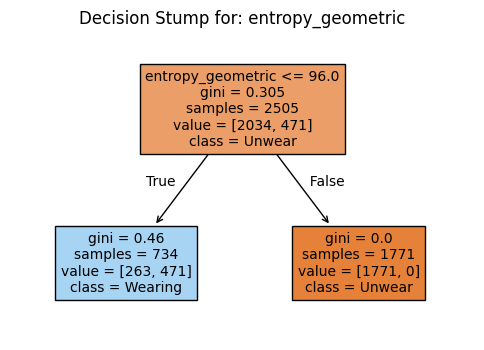

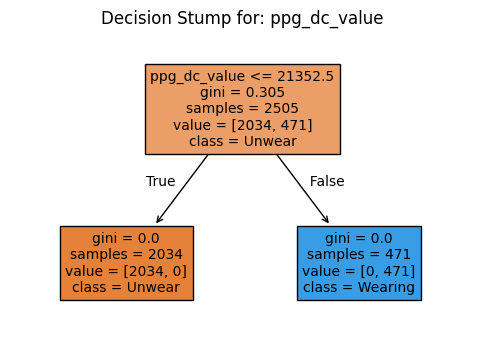

In [41]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# ==========================================
# 1. 准备设置
# ==========================================
# 确保使用正确的 DataFrame 变量名 (这里统一用 green_df_12)
feature_names = ['entropy_geometric', 'zero_crossing_rate', 'ppg_dc_value']
thresholds = {}

print("=== 单特征阈值训练结果 ===")

# ==========================================
# 2. 循环训练每个特征
# ==========================================
for feat in feature_names: # 修复点1: 使用定义好的 feature_names 列表
    
    # 提取单列特征 (注意: 使用双中括号 [[feat]] 保持为 DataFrame 格式)
    X_single = green_df_12[[feat]] 
    y = green_df_12['Label']
    
    # 训练深度为 1 的树 (Decision Stump)
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_single, y)
    
    # --- 获取阈值逻辑 ---
    # 树的结构: node 0 是根, node 1 是左子节点(<= threshold), node 2 是右子节点(> threshold)
    thresh = clf.tree_.threshold[0] # type: ignore
    
    # 简单的逻辑判断方向: 检查左子节点 (value < thresh) 的样本分布
    # clf.tree_.value[node_index][0][class_index]
    # class_index 0 是 Unwear, 1 是 Wearing
    n_unwear_left = clf.tree_.value[1][0][0]
    n_wearing_left = clf.tree_.value[1][0][1]
    
    # 如果左边(小于阈值)的 Wearing 更多,说明 "越小越可能是佩戴"
    is_lower_better = n_wearing_left > n_unwear_left
    direction = "<=" if is_lower_better else ">"
    
    accuracy = clf.score(X_single, y)
    thresholds[feat] = (thresh, direction)
    
    # --- 打印结果 ---
    print(f"\n特征: [{feat}]")
    print(f"  -> 最佳阈值: {thresh:.2f}")
    print(f"  -> 判定规则: 如果 {feat} {direction} {thresh:.2f} 则可能是佩戴")
    print(f"  -> 单特征准确率: {accuracy*100:.1f}%")
    print(F"\n--- 深度决策树规则 ({feat}) ---")
    # feature_names 顺序必须和 X 的列顺序一致
    r = export_text(clf, feature_names=[feat])
    print(r)
    # --- 绘图逻辑 (修复点2) ---
    plt.figure(figsize=(6, 4)) # 不需要太大
    plot_tree(clf, 
              feature_names=[feat], # 关键修复: 这里必须只传当前训练的那一个特征名
              class_names=['Unwear', 'Wearing'], 
              filled=True, 
              fontsize=10)
    plt.title(f"Decision Stump for: {feat}")
    # plt.show() # 加上 show() 确保每张图都能显示出来

In [46]:

# 测试 ppg_dc_value
test_threshold_generic(green_df_12, 18000, 'ppg_dc_value', '<=')

阈值测试: ppg_dc_value <= 18000.00
总体准确率: 99.96%

分类详情:
  正确分类为 Unwear:  2033 个
  正确分类为 Wearing: 471 个
  误判为 Wearing:     1 个 (实际是 Unwear)
  误判为 Unwear:      0 个 (实际是 Wearing)

总样本数: 2505

按设备分析:
  d9e5: 100.00%
  e61b: 100.00%
  0b99: 100.00%
  5d4d: 100.00%
  28d1: 100.00%
  8e26: 100.00%
  5ab5: 100.00%
  d3fe: 99.62%
  9ec9: 100.00%
  cbaf: 100.00%


(0.9996007984031936,
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 2500    1
 2501    1
 2502    1
 2503    1
 2504    1
 Name: ppg_dc_value, Length: 2505, dtype: int64)

In [47]:

# ==========================================
# 1. 准备设置
# ==========================================
# 确保使用正确的 DataFrame 变量名 
feature_names = ['entropy_geometric', 'zero_crossing_rate', 'ppg_dc_value']
thresholds = {}

print("=== 单特征阈值训练结果 ===")

# ==========================================
# 2. 循环训练每个特征
# ==========================================
for feat in feature_names: # 修复点1: 使用定义好的 feature_names 列表
    
    # 提取单列特征 (注意: 使用双中括号 [[feat]] 保持为 DataFrame 格式)
    X_single = green_df_13[[feat]] 
    y = green_df_13['Label']
    
    # 训练深度为 1 的树 (Decision Stump)
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_single, y)
    
    # --- 获取阈值逻辑 ---
    # 树的结构: node 0 是根, node 1 是左子节点(<= threshold), node 2 是右子节点(> threshold)
    thresh = clf.tree_.threshold[0]
    
    # 简单的逻辑判断方向: 检查左子节点 (value < thresh) 的样本分布
    # clf.tree_.value[node_index][0][class_index]
    # class_index 0 是 Unwear, 1 是 Wearing
    n_unwear_left = clf.tree_.value[1][0][0]
    n_wearing_left = clf.tree_.value[1][0][1]
    
    # 如果左边(小于阈值)的 Wearing 更多,说明 "越小越可能是佩戴"
    is_lower_better = n_wearing_left > n_unwear_left
    direction = "<=" if is_lower_better else ">"
    
    accuracy = clf.score(X_single, y)
    thresholds[feat] = (thresh, direction)
    
    # --- 打印结果 ---
    print(f"\n特征: [{feat}]")
    print(f"  -> 最佳阈值: {thresh:.2f}")
    print(f"  -> 判定规则: 如果 {feat} {direction} {thresh:.2f} 则可能是佩戴")
    print(f"  -> 单特征准确率: {accuracy*100:.1f}%")
    print(F"\n--- 深度决策树规则 ({feat}) ---")
    # feature_names 顺序必须和 X 的列顺序一致
    r = export_text(clf, feature_names=['IR_Diff'])
    print(r)
    # --- 绘图逻辑 (修复点2) ---
    plt.figure(figsize=(6, 4)) # 不需要太大
    plot_tree(clf, 
              feature_names=[feat], # 关键修复: 这里必须只传当前训练的那一个特征名
              class_names=['Unwear', 'Wearing'], 
              filled=True, 
              fontsize=10)
    plt.title(f"Decision Stump for: {feat}")
    # plt.show() # 加上 show() 确保每张图都能显示出来

=== 单特征阈值训练结果 ===

特征: [entropy_geometric]
  -> 最佳阈值: 72.50
  -> 判定规则: 如果 entropy_geometric <= 72.50 则可能是佩戴
  -> 单特征准确率: 86.1%

--- 深度决策树规则 (entropy_geometric) ---
|--- IR_Diff <= 72.50
|   |--- class: 1
|--- IR_Diff >  72.50
|   |--- class: 0


特征: [zero_crossing_rate]
  -> 最佳阈值: 29.50
  -> 判定规则: 如果 zero_crossing_rate <= 29.50 则可能是佩戴
  -> 单特征准确率: 85.5%

--- 深度决策树规则 (zero_crossing_rate) ---
|--- IR_Diff <= 29.50
|   |--- class: 1
|--- IR_Diff >  29.50
|   |--- class: 0


特征: [ppg_dc_value]
  -> 最佳阈值: 21479.50
  -> 判定规则: 如果 ppg_dc_value > 21479.50 则可能是佩戴
  -> 单特征准确率: 100.0%

--- 深度决策树规则 (ppg_dc_value) ---
|--- IR_Diff <= 21479.50
|   |--- class: 0
|--- IR_Diff >  21479.50
|   |--- class: 1



In [51]:
test_threshold_generic(green_df_13, 18000, 'ppg_dc_value', '<=')

阈值测试: ppg_dc_value <= 18000.00
总体准确率: 100.00%

分类详情:
  正确分类为 Unwear:  986 个
  正确分类为 Wearing: 233 个
  误判为 Wearing:     0 个 (实际是 Unwear)
  误判为 Unwear:      0 个 (实际是 Wearing)

总样本数: 1219

按设备分析:
  d9e5: 100.00%
  e61b: 100.00%
  0b99: 100.00%
  5d4d: 100.00%
  28d1: 100.00%
  8e26: 100.00%
  5ab5: 100.00%
  d3fe: 100.00%
  9ec9: 100.00%
  cbaf: 100.00%


(1.0,
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1214    1
 1215    1
 1216    1
 1217    1
 1218    1
 Name: ppg_dc_value, Length: 1219, dtype: int64)

=== 每个设备在 Wearing 和 Unwear 场景下的参数统计 ===

设备 8e26:
  Unwear 场景:
    entropy_geometric: 平均 = 4064.93, 标准差 = 4818.86
    ppg_g_current: 平均 = 20.25, 标准差 = 3.04
    ppg_dc_value: 平均 = 7937.50, 标准差 = 1812.76
    ac_amplitude: 平均 = 218.09, 标准差 = 590.96
    std: 平均 = 40.12, 标准差 = 110.89
    entropy_permutation: 平均 = 2549.32, 标准差 = 109.32
    zero_crossing_rate: 平均 = 42.85, 标准差 = 6.84
  Wearing 场景:
    entropy_geometric: 平均 = 32.08, 标准差 = 13.81
    ppg_g_current: 平均 = 5.51, 标准差 = 0.50
    ppg_dc_value: 平均 = 27504.68, 标准差 = 2350.75
    ac_amplitude: 平均 = 643.19, 标准差 = 263.55
    std: 平均 = 152.96, 标准差 = 65.05
    entropy_permutation: 平均 = 2185.00, 标准差 = 190.27
    zero_crossing_rate: 平均 = 8.00, 标准差 = 3.72

设备 dcc2:
  Unwear 场景:
    entropy_geometric: 平均 = 5918.32, 标准差 = 4855.73
    ppg_g_current: 平均 = 8.75, 标准差 = 1.09
    ppg_dc_value: 平均 = 17228.66, 标准差 = 1976.59
    ac_amplitude: 平均 = 113.58, 标准差 = 195.50
    std: 平均 = 19.78, 标准差 = 22.48
    entropy_permutation: 平均 = 2551.06, 标准差 = 52.06
    ze

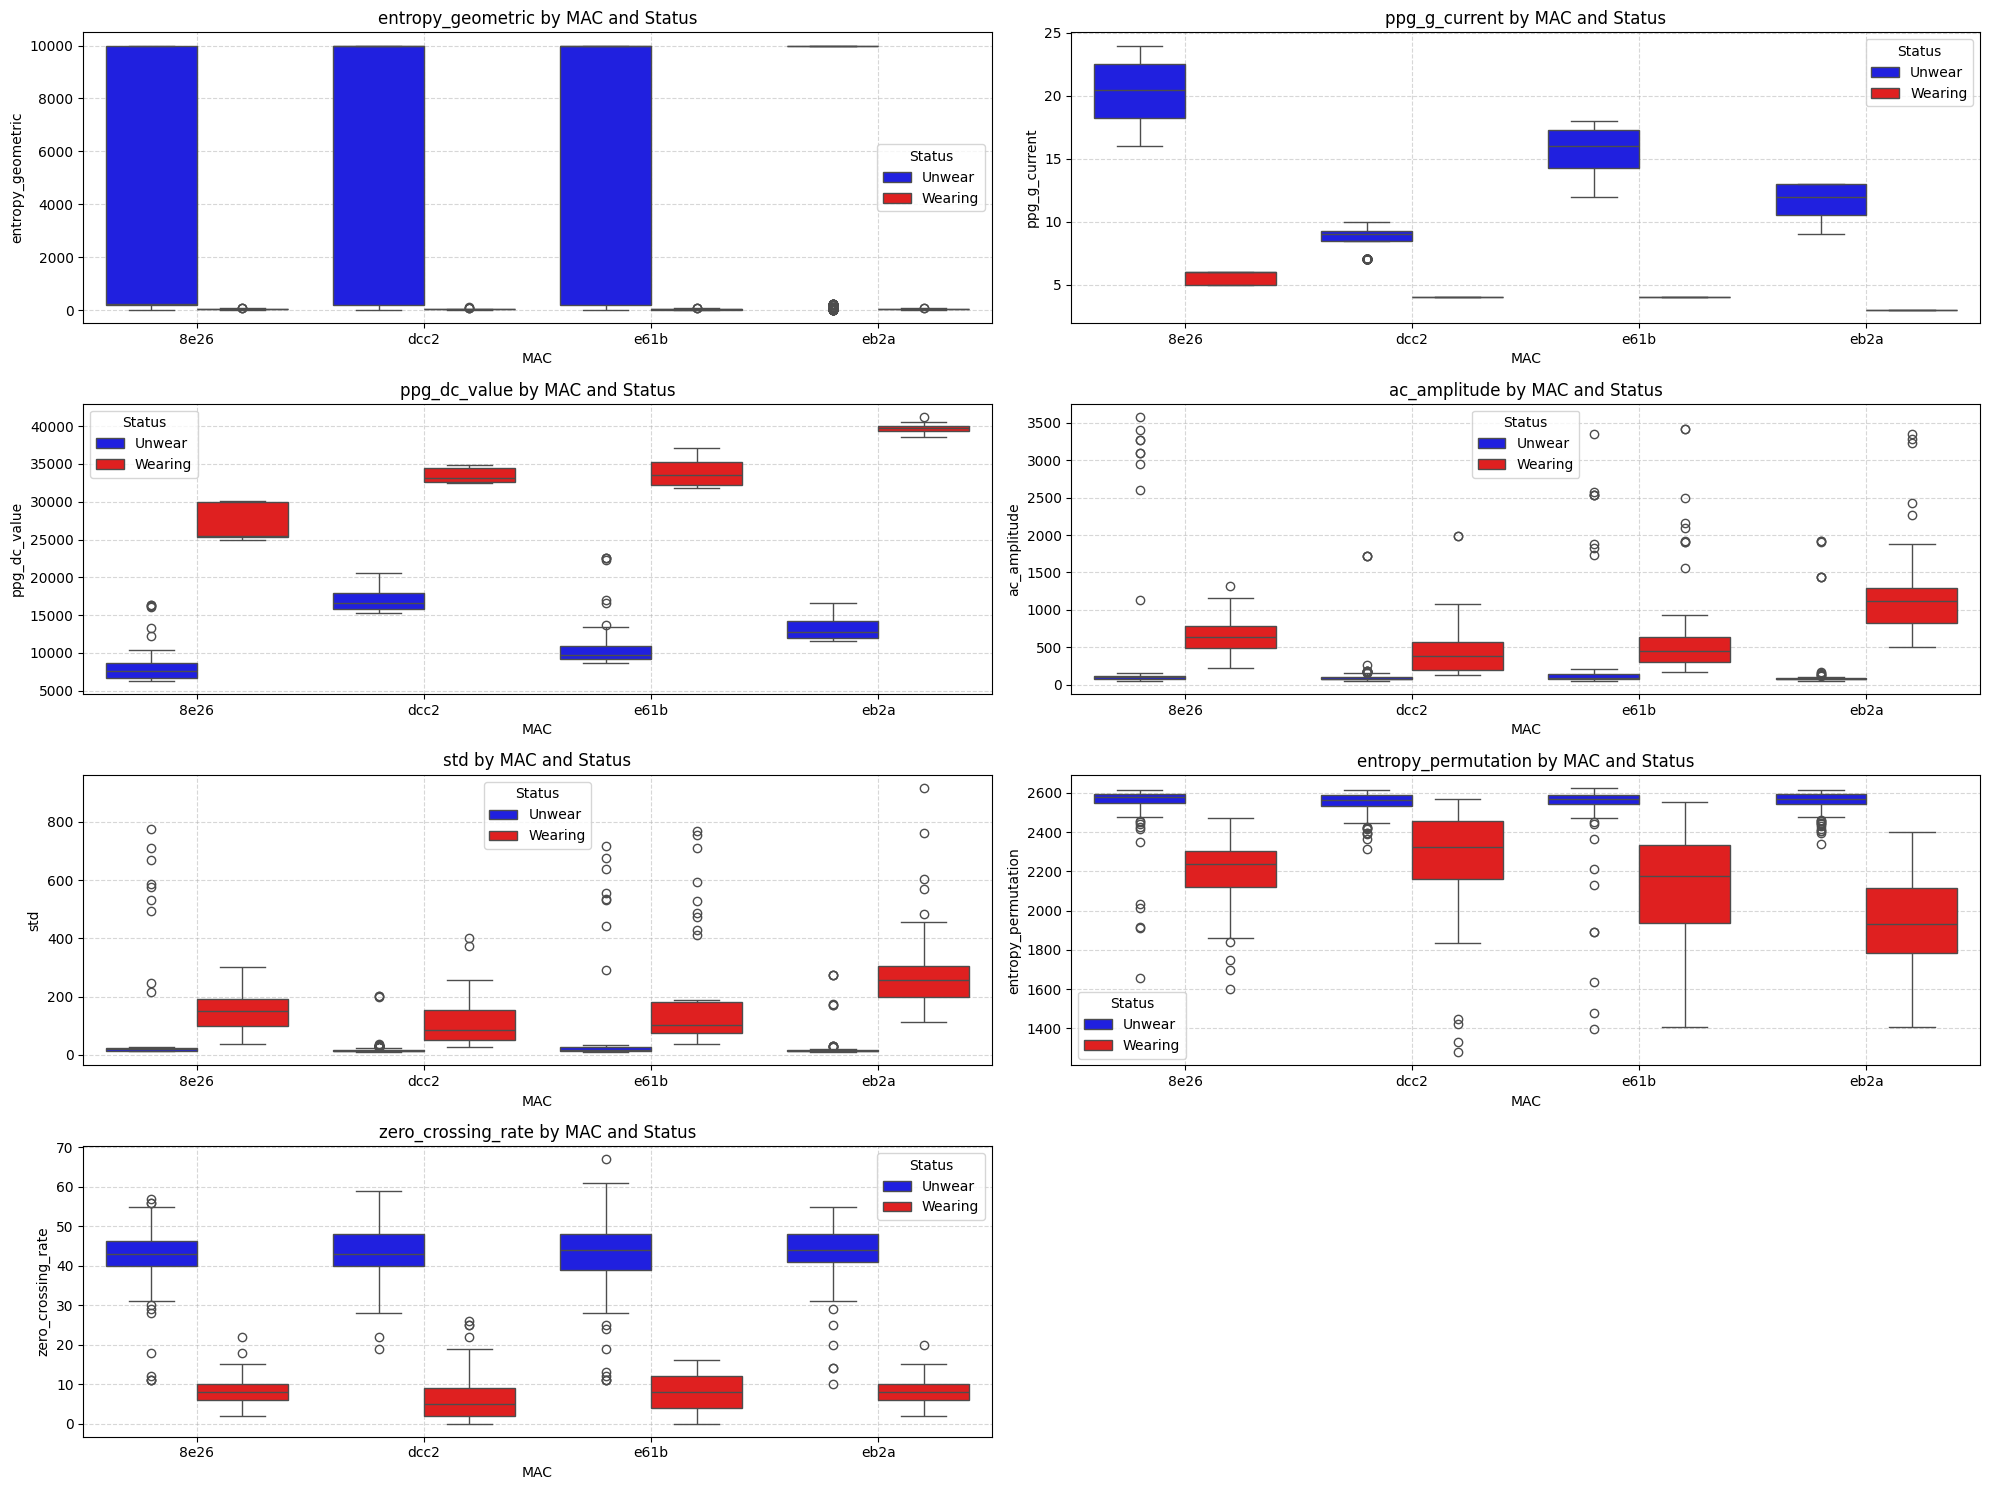

In [18]:
# 分析每个设备在各个场景下的参数
# 假设场景是 Wearing 和 Unwear(基于 Status)
# 参数：entropy_geometric, ppg_g_current, ppg_dc_value, ac_amplitude, std, entropy_permutation, zero_crossing_rate

params = ['entropy_geometric', 'ppg_g_current', 'ppg_dc_value', 'ac_amplitude', 'std', 'entropy_permutation', 'zero_crossing_rate']

print("=== 每个设备在 Wearing 和 Unwear 场景下的参数统计 ===")

for mac in valid_macs:
    print(f"\n设备 {mac}:")
    for status in ['Unwear', 'Wearing']:
        subset = green_df_12[(green_df_12['MAC'] == mac) & (green_df_12['Status'] == status)]
        if not subset.empty:
            print(f"  {status} 场景:")
            for param in params:
                mean_val = subset[param].mean()
                std_val = subset[param].std()
                print(f"    {param}: 平均 = {mean_val:.2f}, 标准差 = {std_val:.2f}")
        else:
            print(f"  {status} 场景: 无数据")

# 可视化：为每个参数绘制按 MAC 和 Status 的 boxplot
plt.figure(figsize=(20, 15))
for i, param in enumerate(params):
    plt.subplot(4, 2, i+1)
    sns.boxplot(data=green_df_12[green_df_12['MAC'].isin(valid_macs)], x='MAC', y=param, hue='Status', palette={'Unwear': 'blue', 'Wearing': 'red'})
    plt.title(f'{param} by MAC and Status')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# dcc2    0.222505
# eb2a    0.364111
# 8e26    0.370210
# e61b    0.508291

In [19]:
# 查询设备 dcc2 的各个文件的参数
# 参数：entropy_geometric, ppg_g_current, ppg_dc_value, ac_amplitude, std, entropy_permutation, zero_crossing_rate

mac_to_query = 'dcc2'
params = ['entropy_geometric', 'ppg_g_current', 'ppg_dc_value', 'ac_amplitude', 'std', 'entropy_permutation', 'zero_crossing_rate']

# 过滤 dcc2 的数据
dcc2_data = green_df_12[green_df_12['MAC'] == mac_to_query]

# 按文件分组,计算参数的平均值
grouped = dcc2_data.groupby('Filename')[params].mean()

print(f"=== 设备 {mac_to_query} 的各个文件的参数平均值 ===")
print(grouped)

# 也可以显示每个文件的 Status
file_status = dcc2_data.groupby('Filename')['Status'].first()
print(f"\n文件状态:")
print(file_status)

=== 设备 dcc2 的各个文件的参数平均值 ===
                                               entropy_geometric  \
Filename                                                           
Wear_Unwear_SHB_20251212_173906_dcc2_log.txt         1688.603774   
Wear_Unwear_SHB_20251212_174237_dcc2_log.txt         7938.471698   
Wear_Unwear_SHB_20251212_174548_dcc2_log.txt         5724.603774   
Wear_Unwear_SHB_20251212_174921_dcc2_log.txt         8321.584906   
Wear_Wearing_SHB_20251212_175547_dcc2_log.txt          31.377358   

                                               ppg_g_current  ppg_dc_value  \
Filename                                                                     
Wear_Unwear_SHB_20251212_173906_dcc2_log.txt            10.0  15335.433962   
Wear_Unwear_SHB_20251212_174237_dcc2_log.txt             9.0  15978.037736   
Wear_Unwear_SHB_20251212_174548_dcc2_log.txt             9.0  17148.830189   
Wear_Unwear_SHB_20251212_174921_dcc2_log.txt             7.0  20452.339623   
Wear_Wearing_SHB_20251212_1

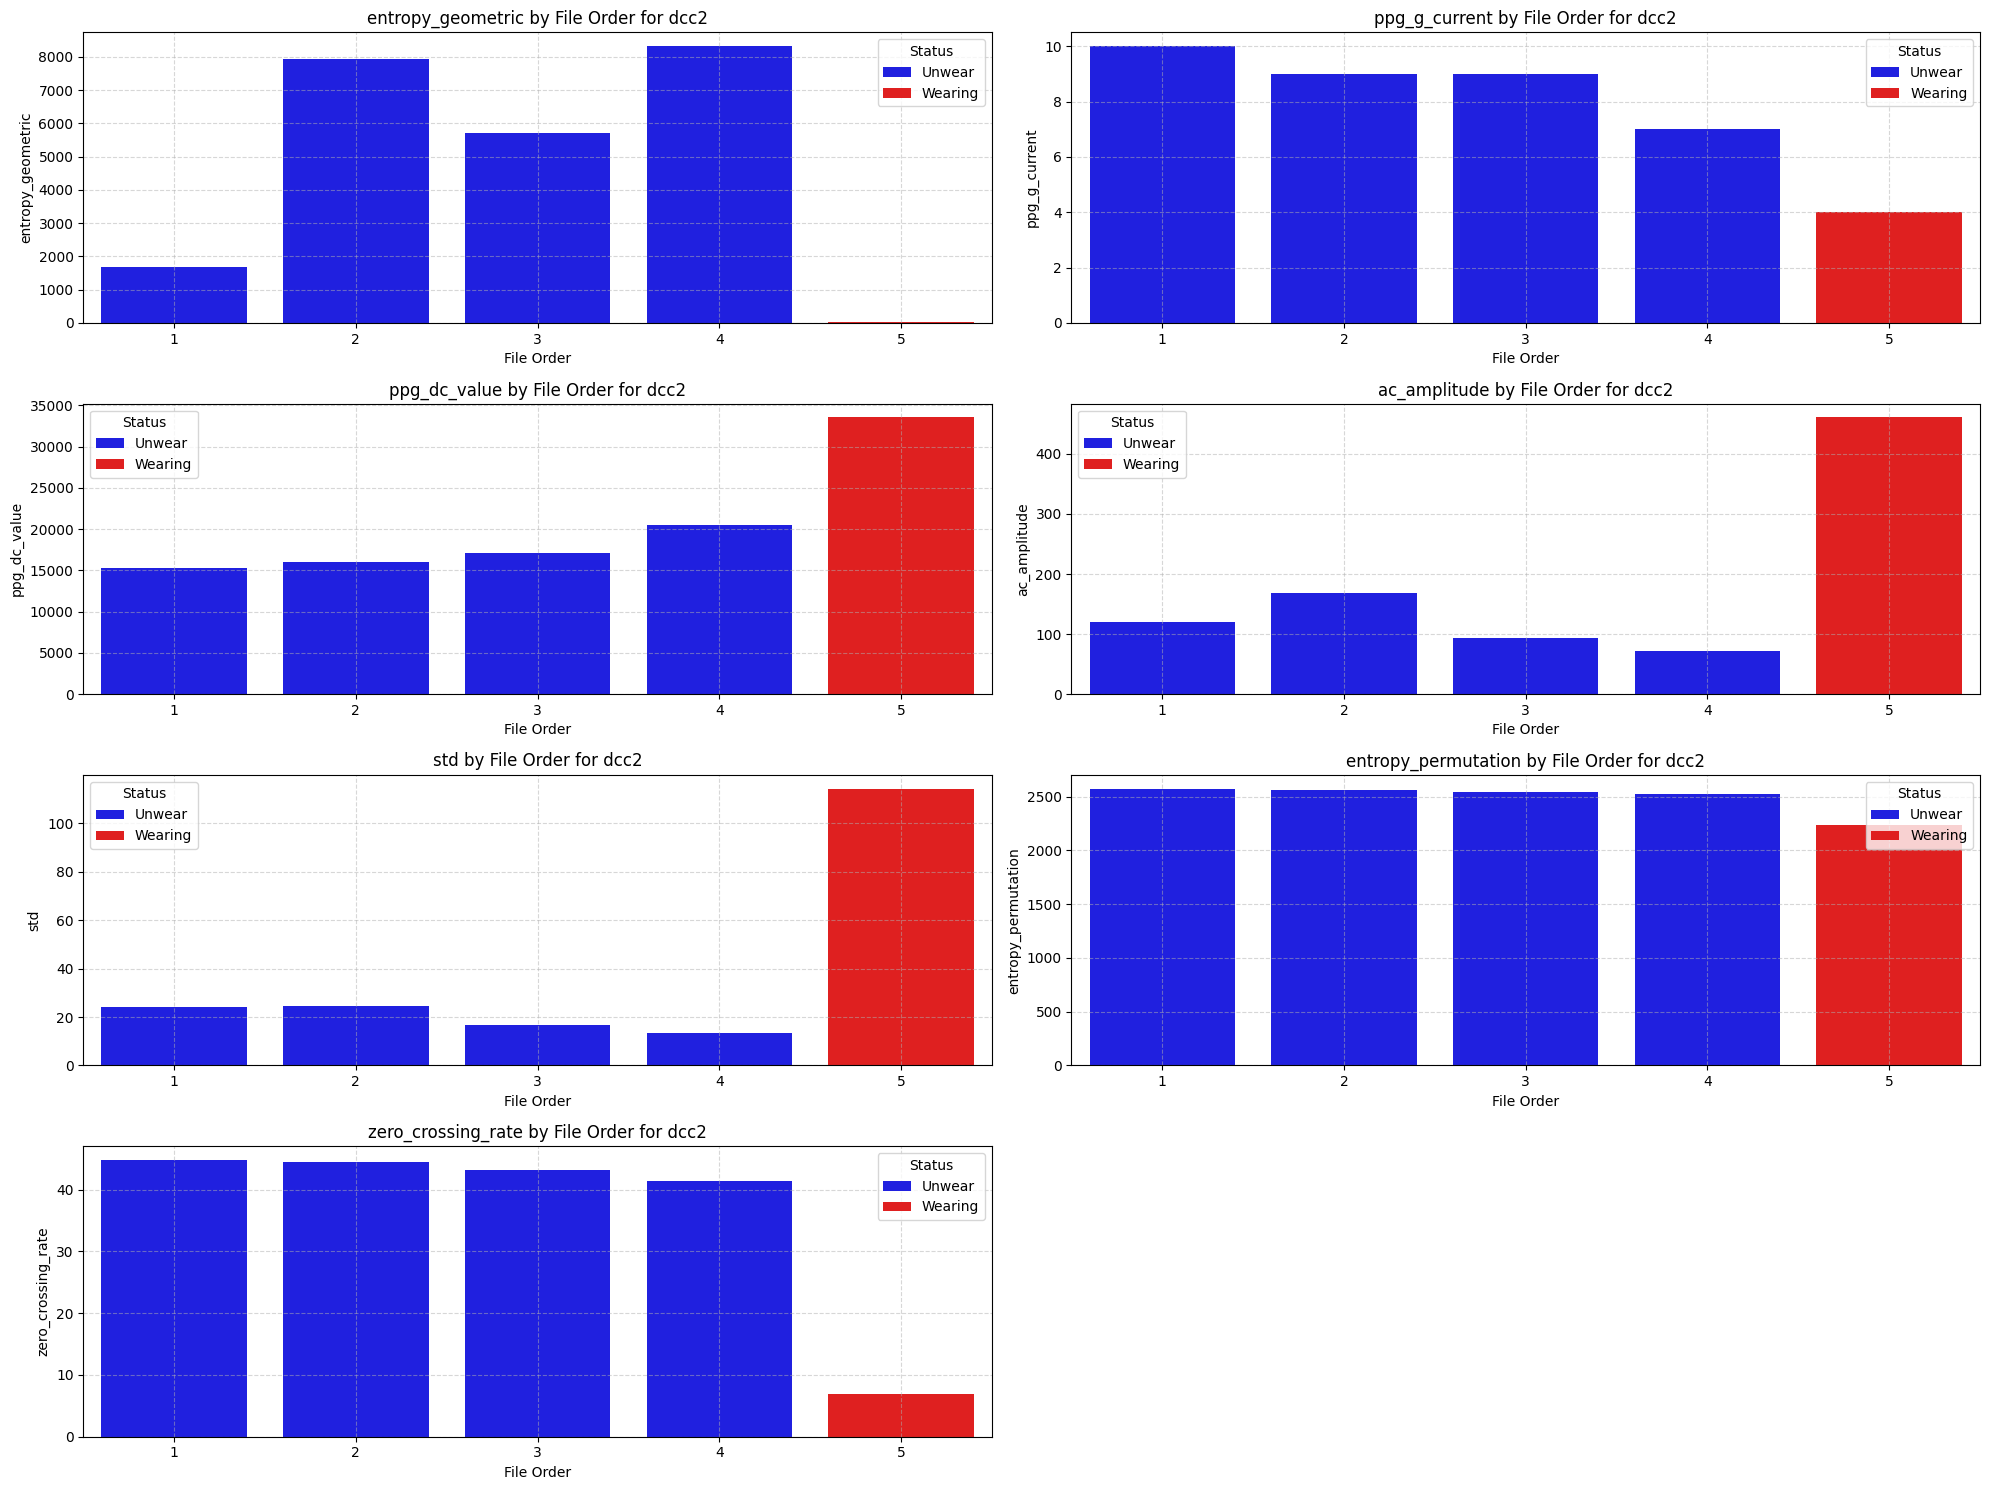

In [21]:
# 绘制设备 dcc2 的各个文件的参数
import matplotlib.pyplot as plt
import seaborn as sns

mac_to_query = 'dcc2'
params = ['entropy_geometric', 'ppg_g_current', 'ppg_dc_value', 'ac_amplitude', 'std', 'entropy_permutation', 'zero_crossing_rate']

# 过滤 dcc2 的数据
dcc2_data = green_df_12[green_df_12['MAC'] == mac_to_query]

# 按文件分组,计算参数的平均值
grouped = dcc2_data.groupby('Filename')[params].mean()

# 获取文件状态
file_status = dcc2_data.groupby('Filename')['Status'].first()

# 合并到 DataFrame
grouped['Status'] = file_status

# 重置索引,使 Filename 成为列
grouped = grouped.reset_index()

# 添加文件顺序作为标签
grouped['File_Order'] = range(1, len(grouped) + 1)

# 绘制每个参数的条形图
plt.figure(figsize=(20, 15))
for i, param in enumerate(params):
    plt.subplot(4, 2, i+1)
    sns.barplot(data=grouped, x='File_Order', y=param, hue='Status', palette={'Unwear': 'blue', 'Wearing': 'red'})
    plt.title(f'{param} by File Order for {mac_to_query}')
    plt.xlabel('File Order')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
# 查询所有有效设备的各个文件的参数
# 参数：entropy_geometric, ppg_g_current, ppg_dc_value, ac_amplitude, std, entropy_permutation, zero_crossing_rate

params = ['entropy_geometric', 'ppg_g_current', 'ppg_dc_value', 'ac_amplitude', 'std', 'entropy_permutation', 'zero_crossing_rate']

for mac_to_query in valid_macs:
    print(f"\n{'='*50}")
    print(f"设备 {mac_to_query} 的各个文件的参数平均值")
    print(f"{'='*50}")
    
    # 过滤该 MAC 的数据
    mac_data = green_df_12[green_df_12['MAC'] == mac_to_query]
    
    # 按文件分组,计算参数的平均值
    grouped = mac_data.groupby('Filename')[params].mean()
    
    print(grouped)
    
    # 显示每个文件的 Status
    file_status = mac_data.groupby('Filename')['Status'].first()
    print(f"\n文件状态:")
    print(file_status)
    print()


设备 8e26 的各个文件的参数平均值
                                               entropy_geometric  \
Filename                                                           
Wear_Unwear_SHB_20251212_171205_8e26_log.txt          572.603774   
Wear_Unwear_SHB_20251212_171542_8e26_log.txt         6651.037736   
Wear_Unwear_SHB_20251212_171929_8e26_log.txt         3149.226415   
Wear_Unwear_SHB_20251212_172253_8e26_log.txt         5886.867925   
Wear_Wearing_SHB_20251212_172619_8e26_log.txt          32.075472   

                                               ppg_g_current  ppg_dc_value  \
Filename                                                                     
Wear_Unwear_SHB_20251212_171205_8e26_log.txt       24.000000   6270.735849   
Wear_Unwear_SHB_20251212_171542_8e26_log.txt       22.000000   6870.698113   
Wear_Unwear_SHB_20251212_171929_8e26_log.txt       19.000000   8235.018868   
Wear_Unwear_SHB_20251212_172253_8e26_log.txt       16.000000  10373.547170   
Wear_Wearing_SHB_20251212_172619_8

In [64]:
folder_path = r"G:\python\rawdata_Wearing\BaseLine" 
all_files = os.listdir(folder_path)
log_files = [f for f in all_files if f.endswith('.txt')]


file_dict = {}

for f in log_files:
            
    # --- A. 提取 MAC ---
    info = parse_filename(f)
    mac_addr = info.get('mac') 
    if not mac_addr:
        continue

    
    label = info.get('label')
    # --- B. 提取 Label (分类) ---
    if "Wearing" == label:
        label = 1 # Wearing
        status_str = "Wearing"
    elif "Unwear" == label:
        label = 0 # Unwear
        status_str = "Unwear"
        continue
    else:
        print(f"未知的标签 {label} 在文件 {f} 中")
        continue # 跳过其他文件

    # --- C. 读取内容 ---
    file_path = os.path.join(folder_path, f)
    print(file_path)
    # file_list.append(file_path)
    name = info.get('name')
    file_dict[name] = []
    parser = WearLogParser()
    i = 0
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
                data = parser.parse_line(line)
                if data:
                    i += 1
                    # 'Status', 'Label', 'Value', 'Filename'
                    data['MAC'] = mac_addr
                    data['Status'] = status_str
                    data['Label'] = label
                    data['Filename'] = filename
                    # print(line, end='')
                    # print(data)
                    # print()
                    # 收集原始数据
                    file_dict[name].append(data)

    if (i == 0):
        print(f"文件 {file_path} 中未找到匹配的 median 数据")

df_dict = {}
for name in file_dict:
    df_dict[name] = pd.DataFrame(file_dict[name]) 


G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_shb_20251219_181416_d9e5_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_shb_20251219_181416_e61b_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_shb_20251219_184934_0b99_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_shb_20251219_184934_5d4d_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_wsf_20251219_174955_28d1_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_wsf_20251219_174955_8e26_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_wsf_20251219_181416_5ab5_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_wsf_20251219_181416_d3fe_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_wsf_20251219_184934_9ec9_log.txt
G:\python\rawdata_Wearing\BaseLine\Wear_Wearing_wsf_20251219_184934_cbaf_log.txt


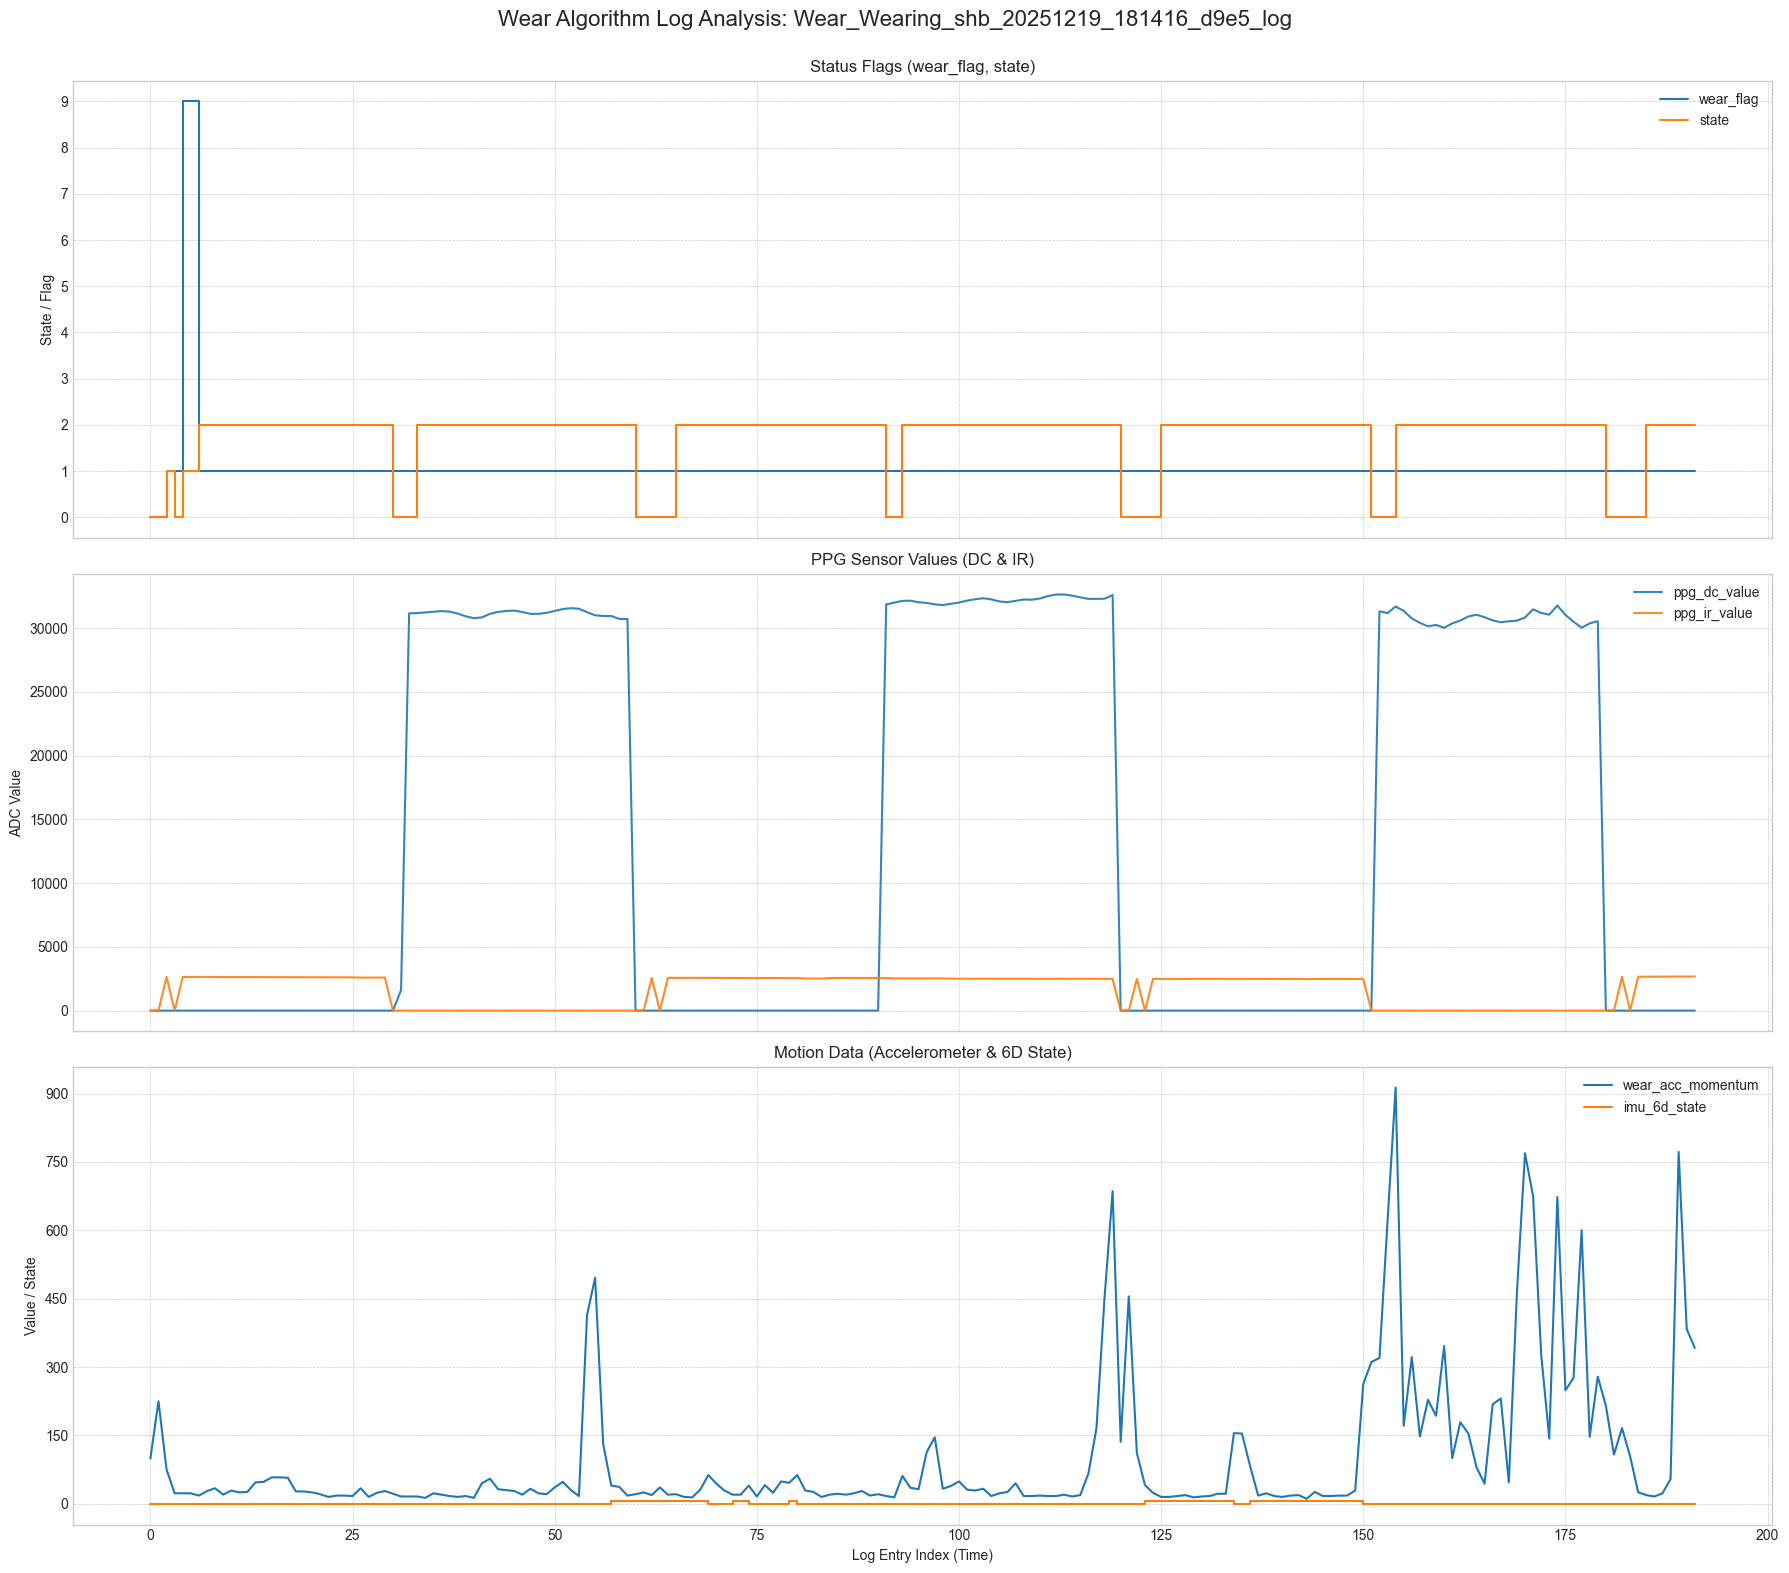

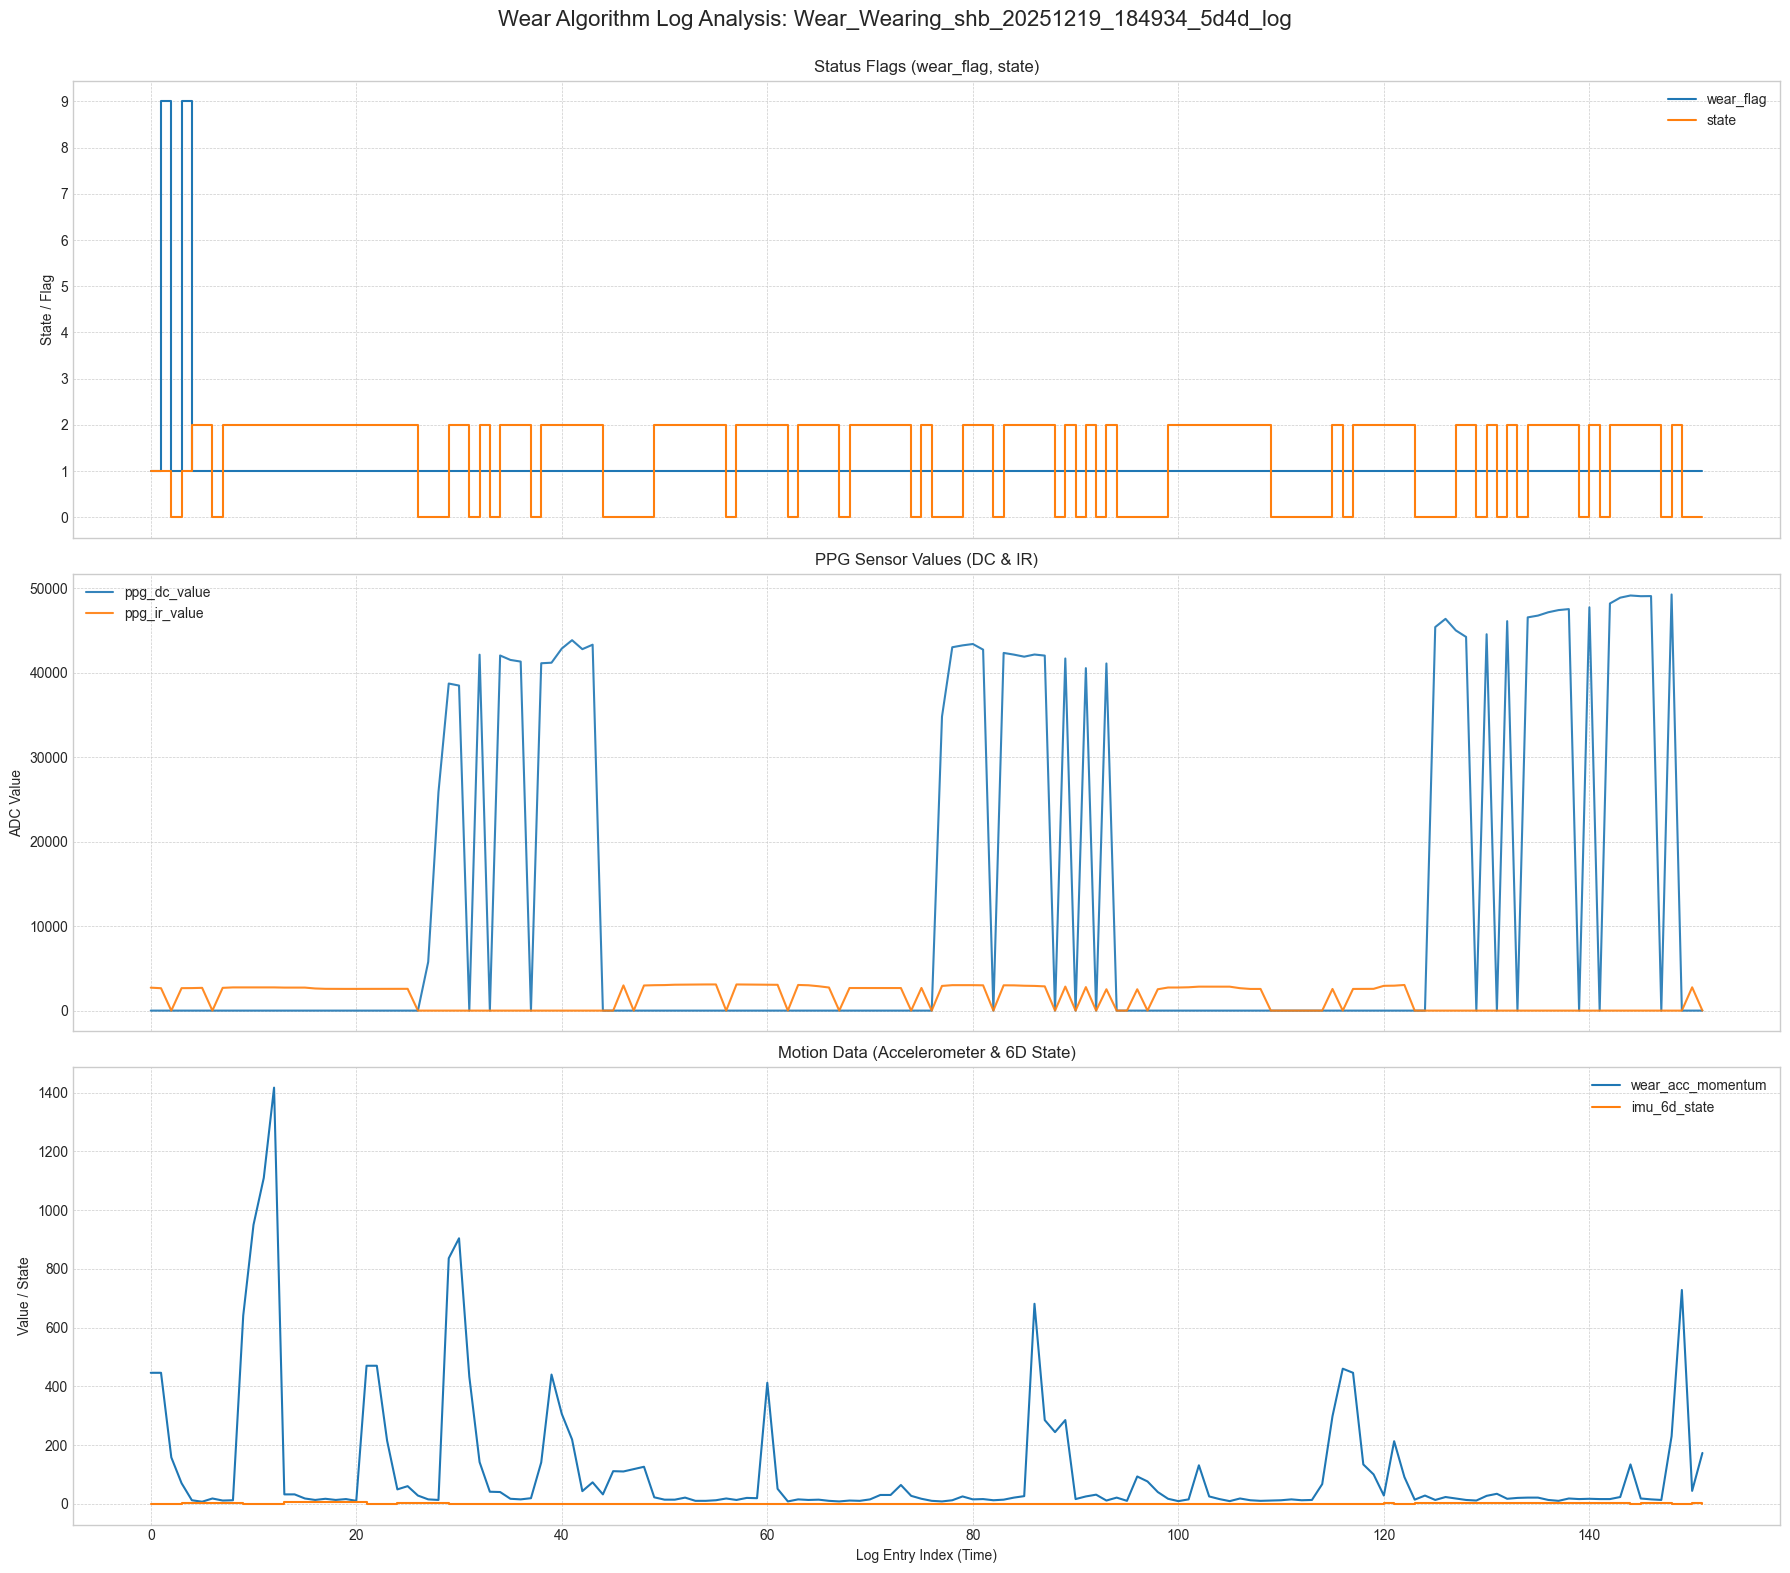

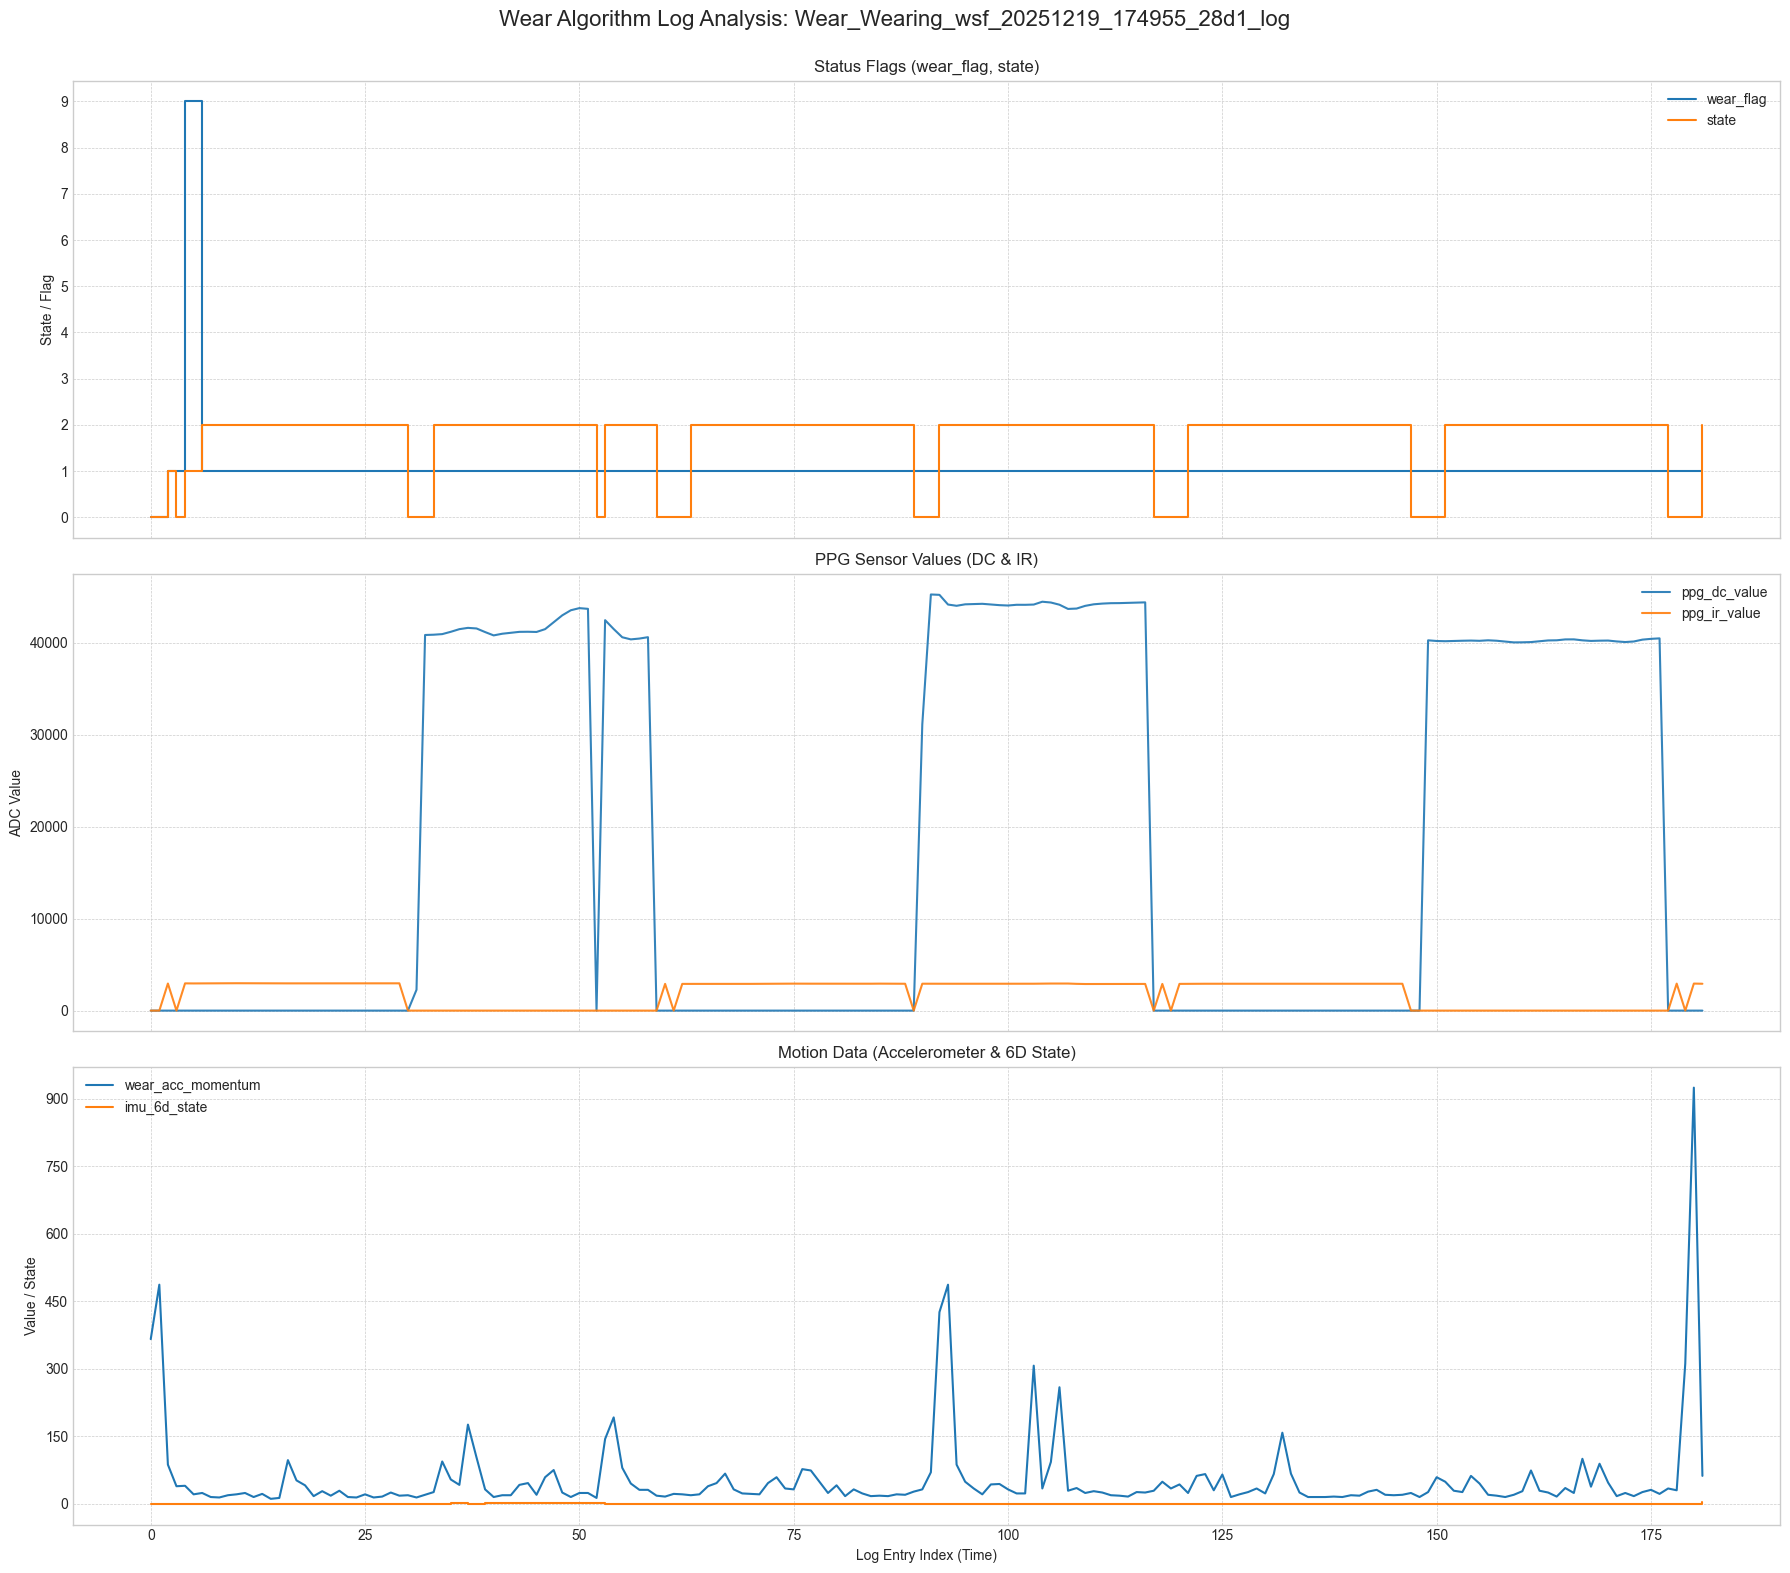

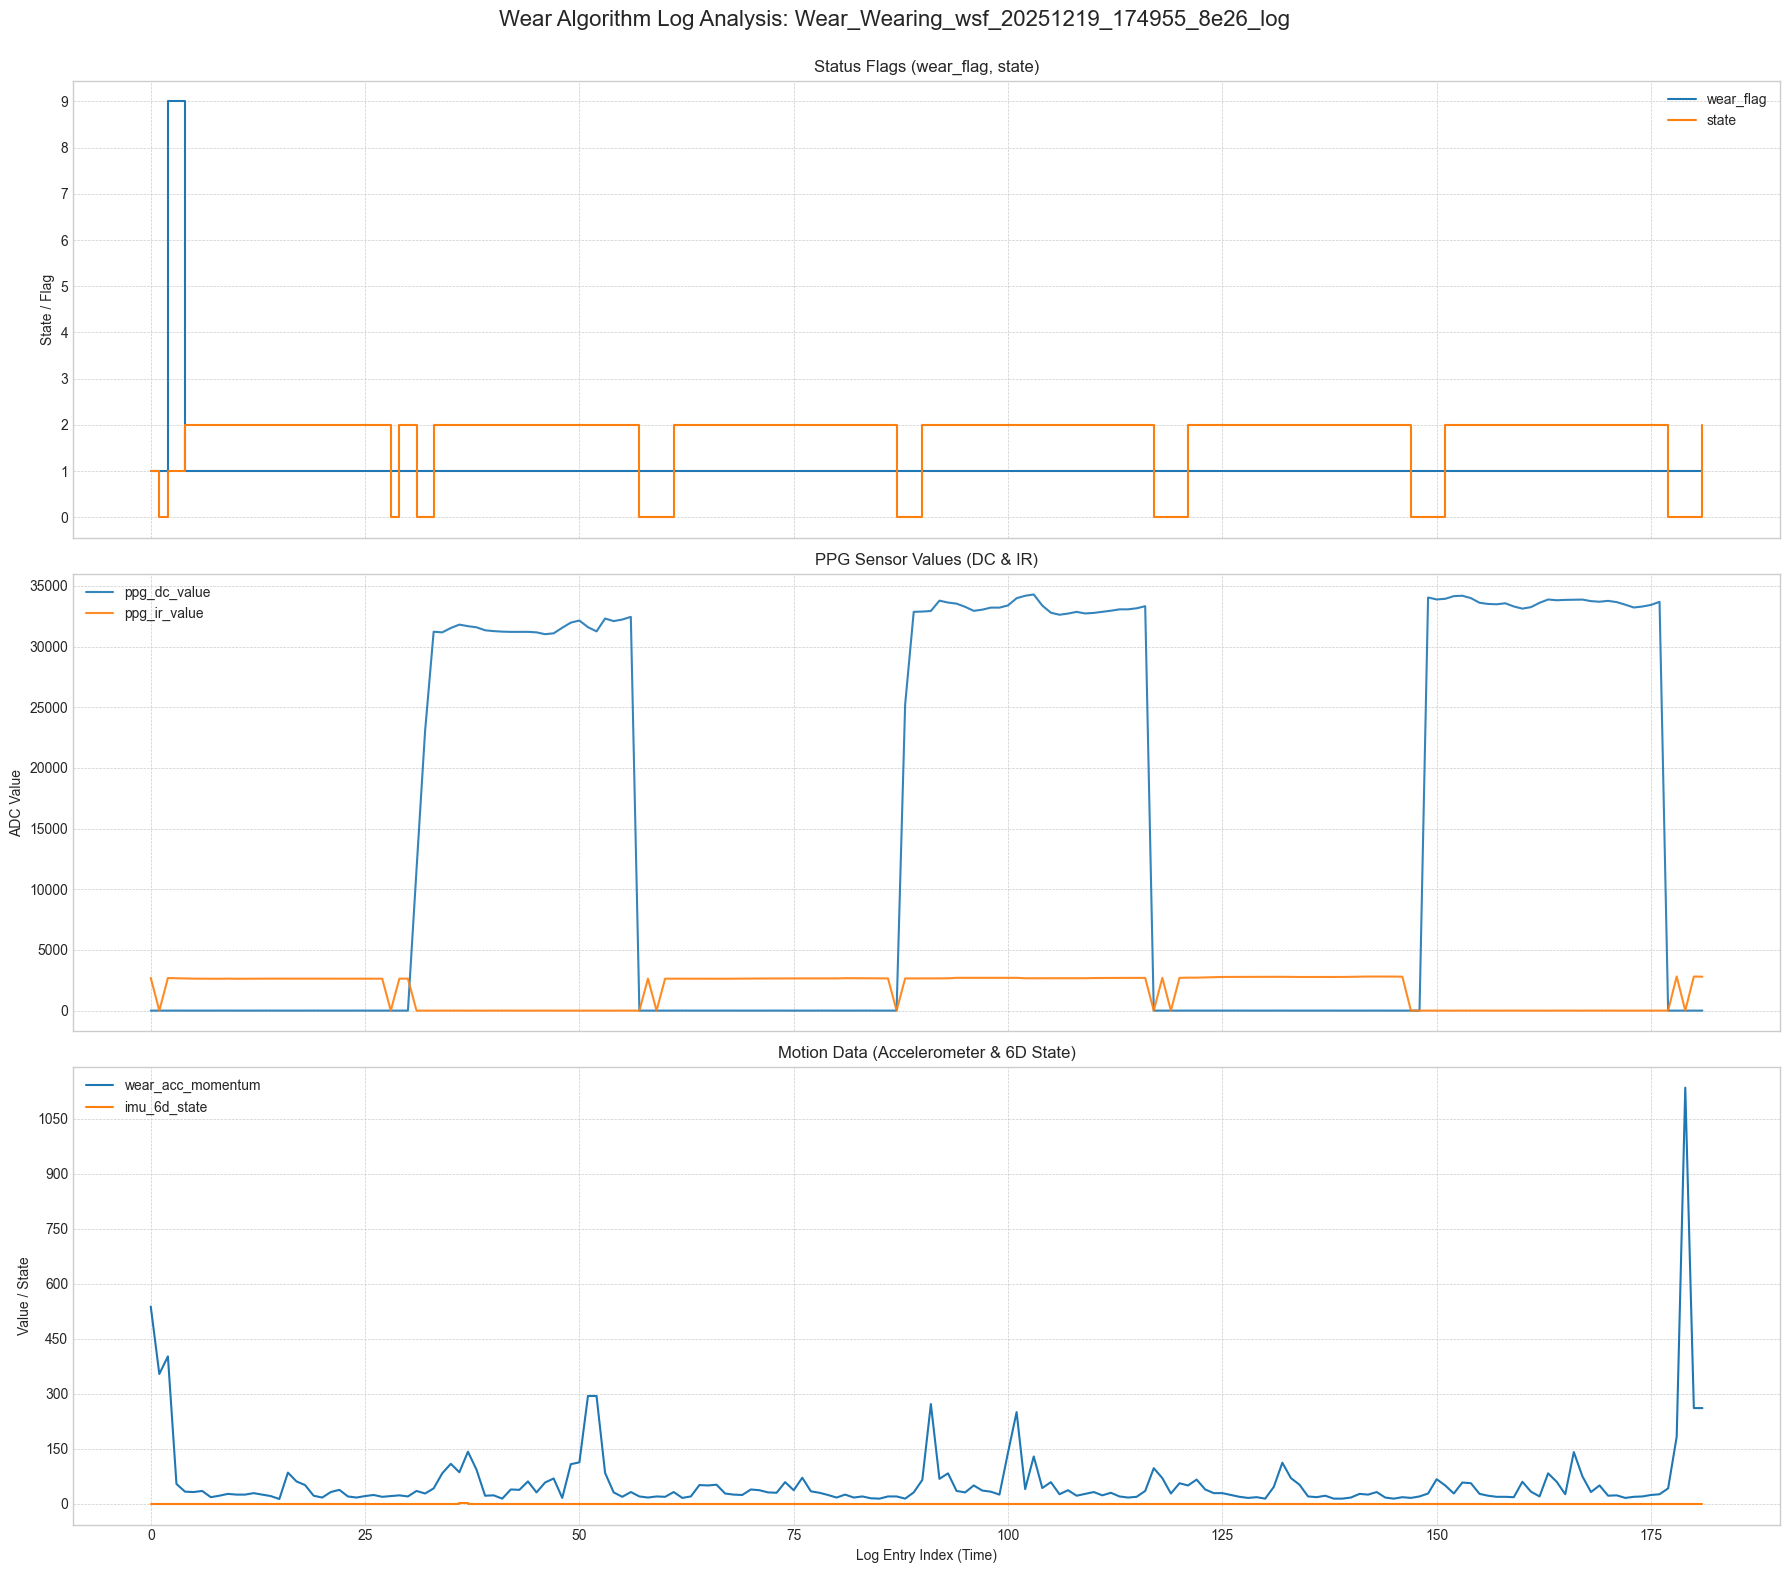

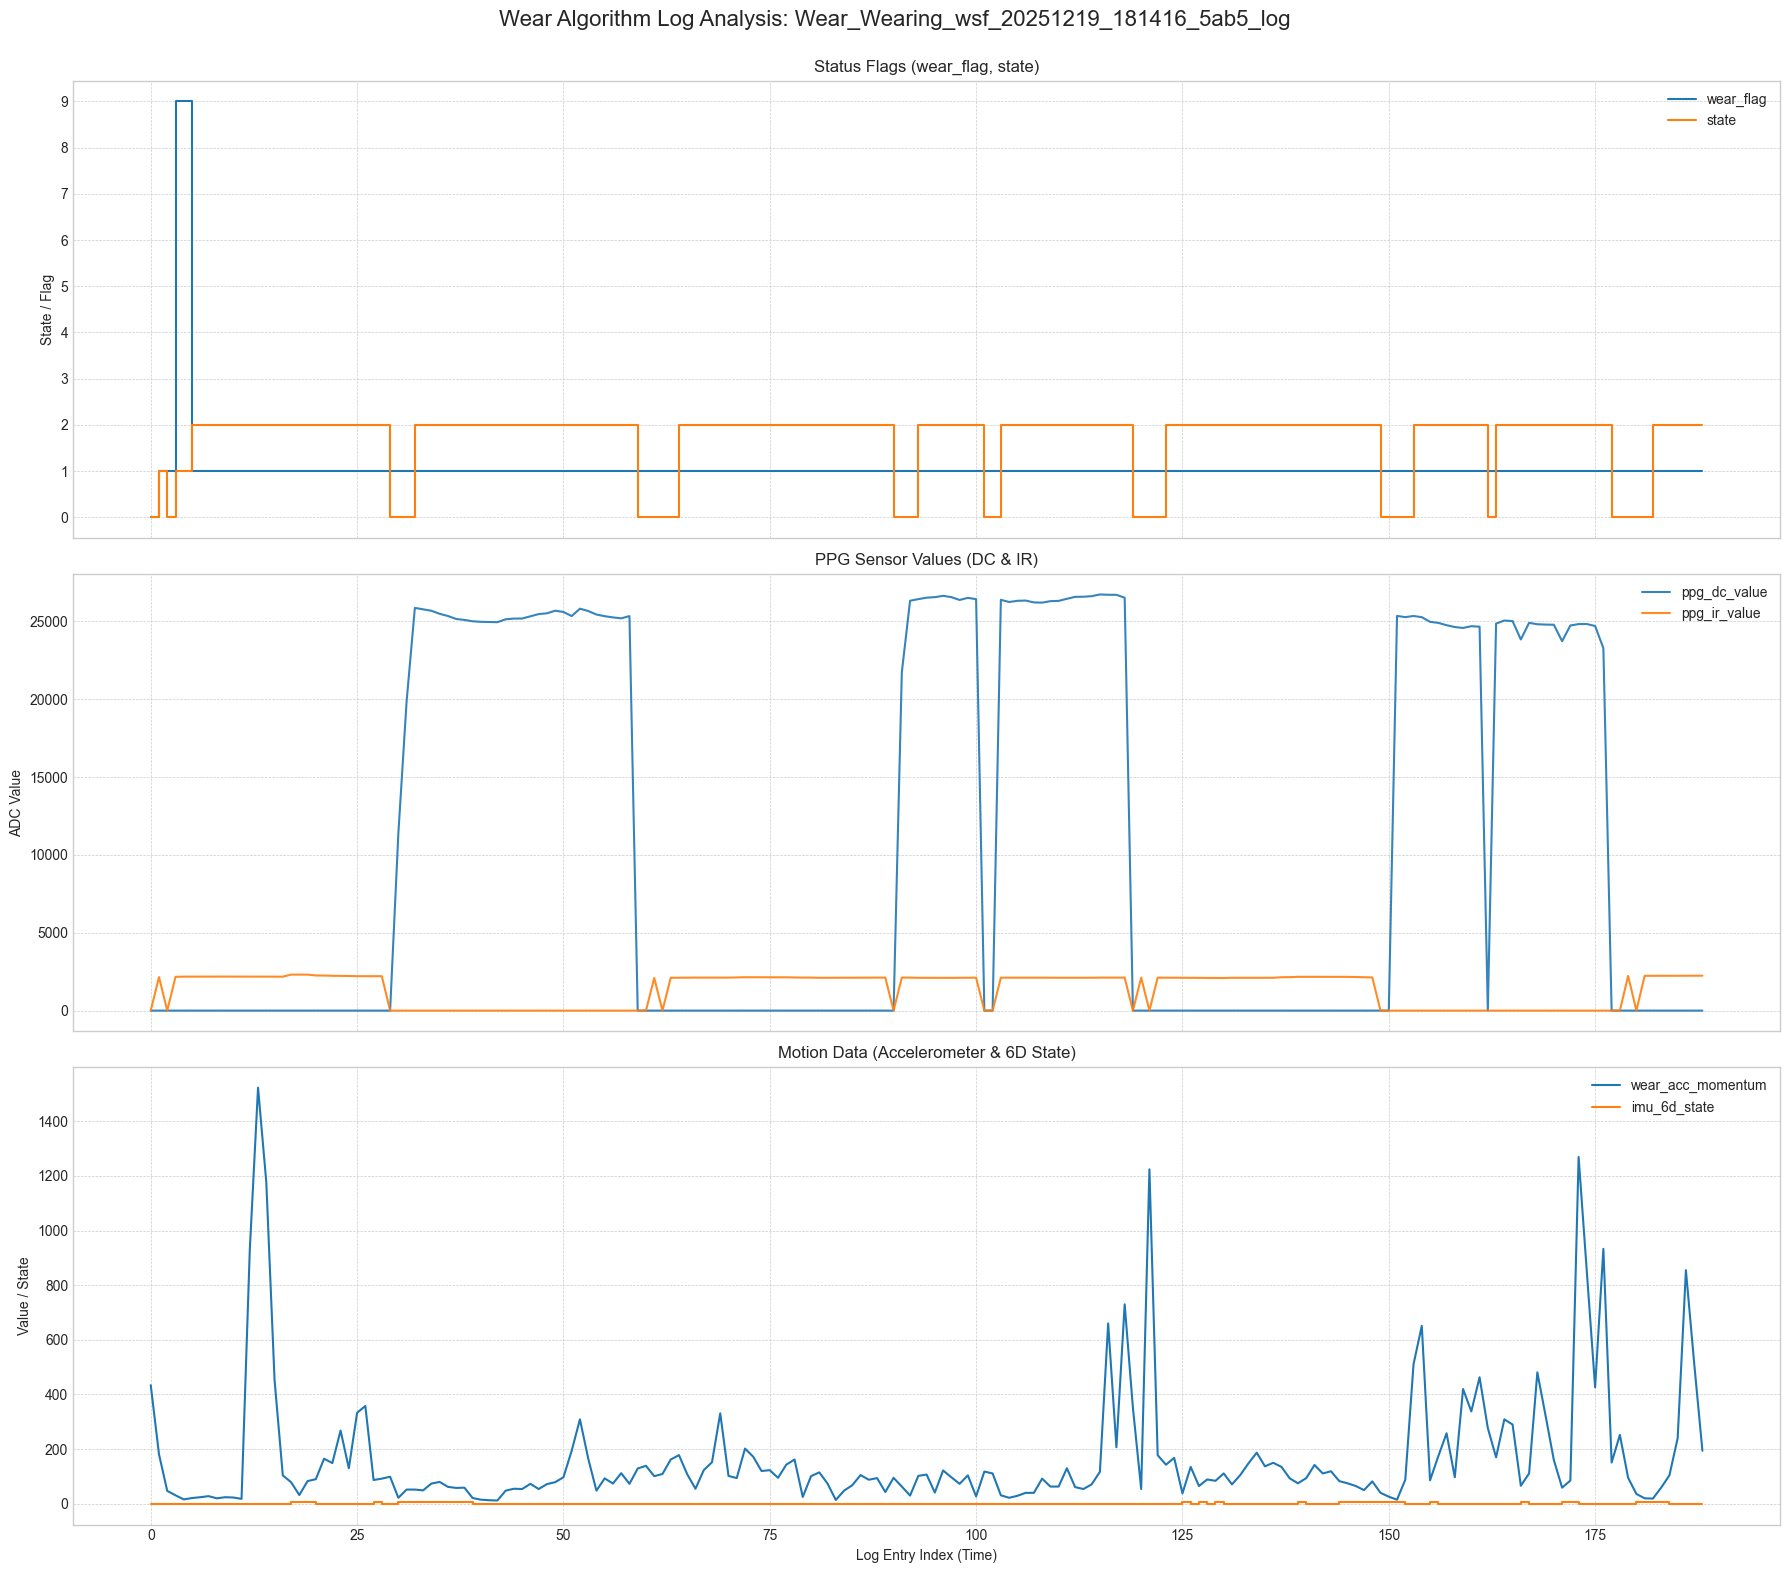

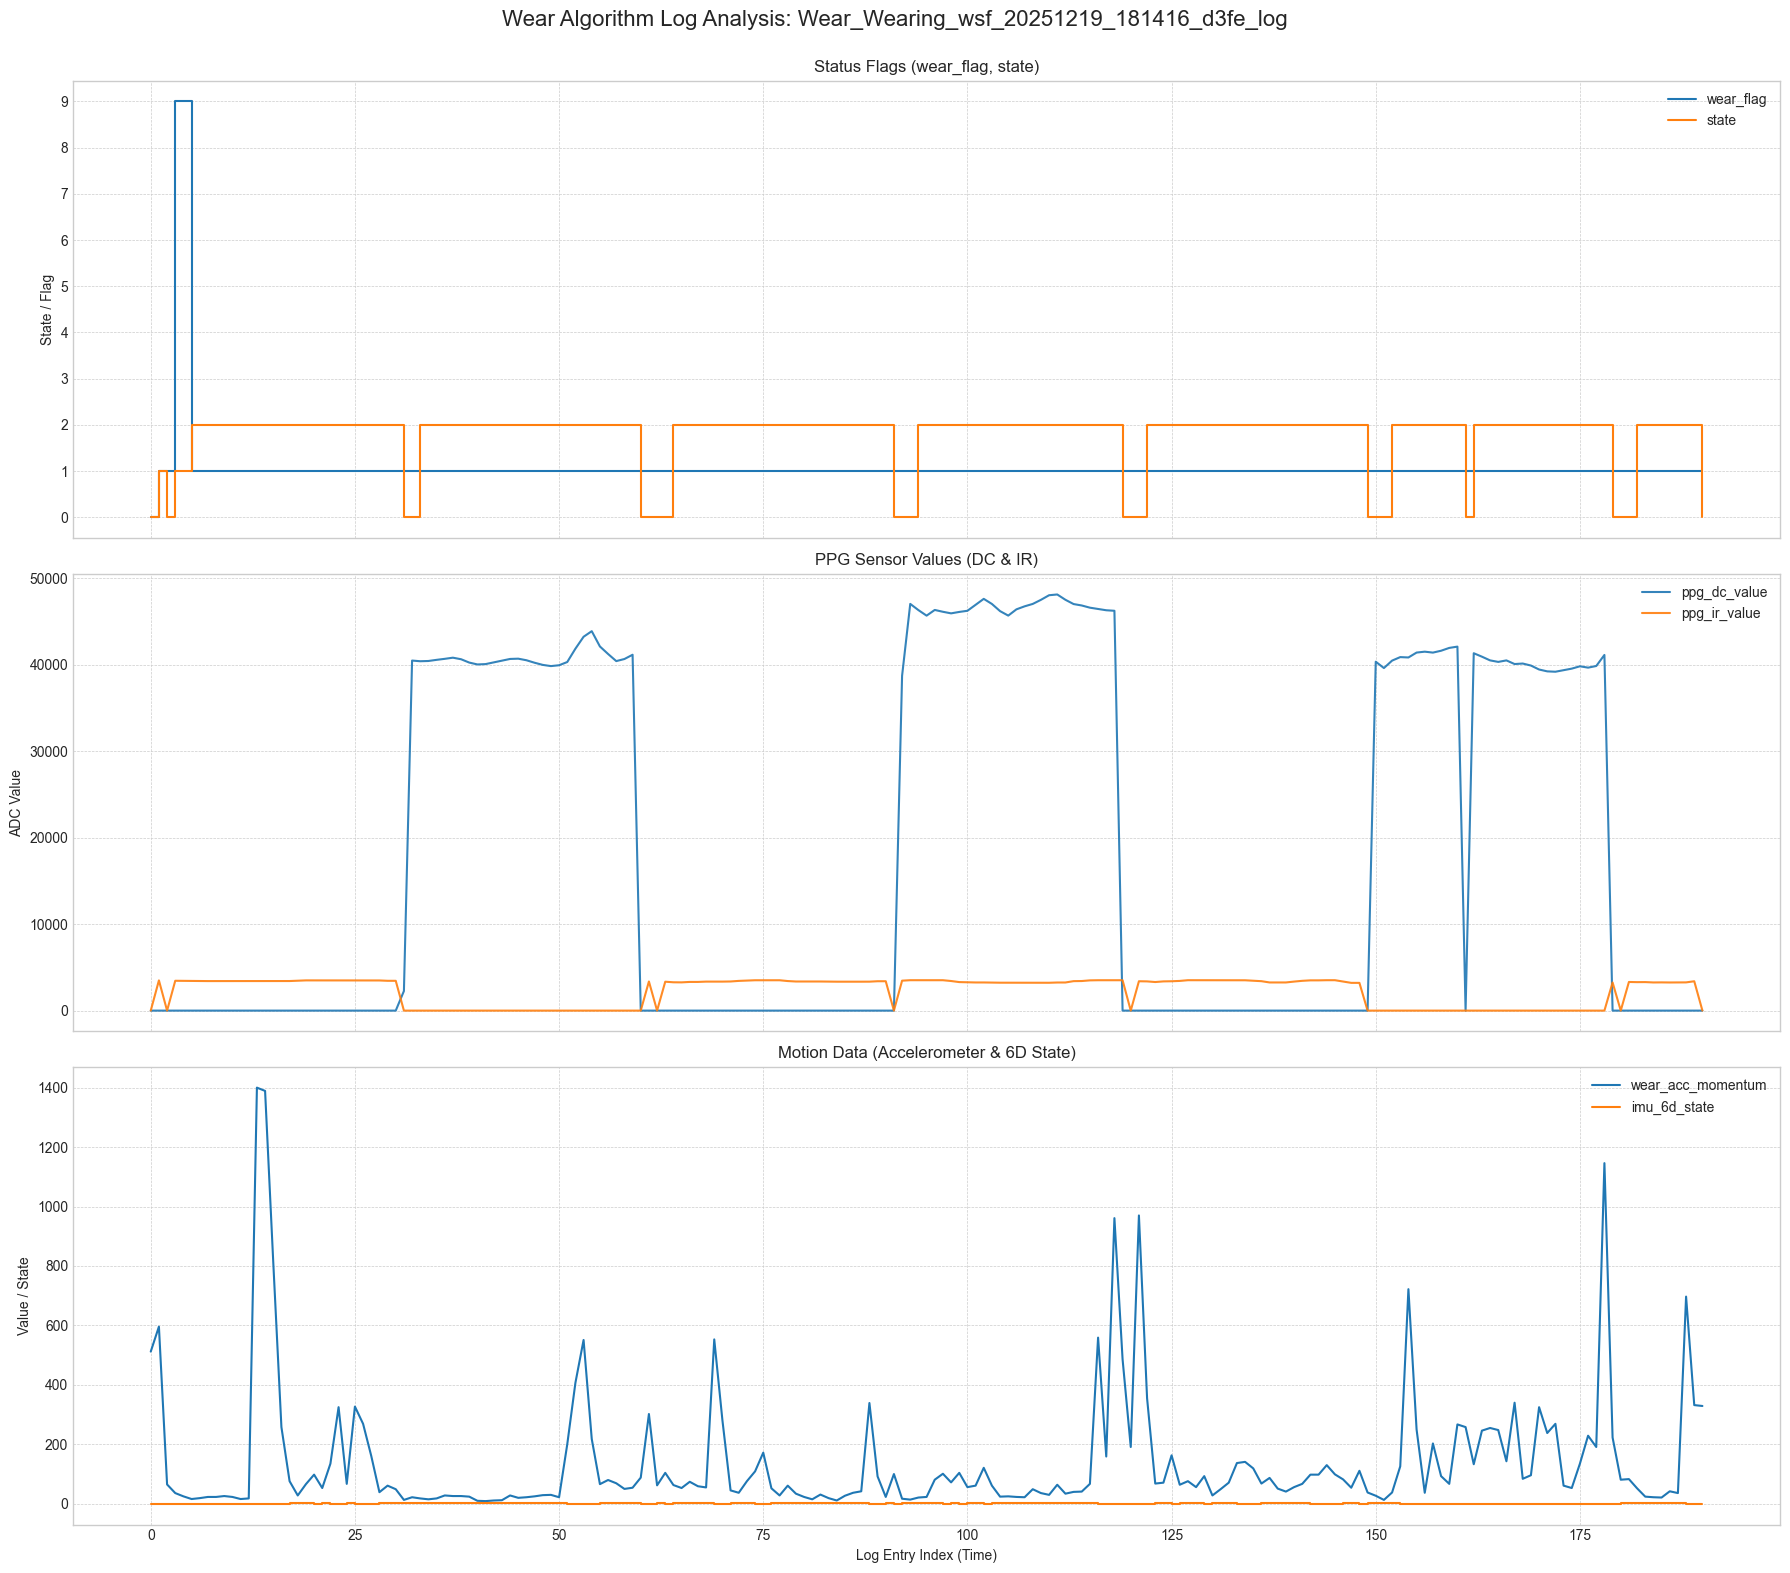

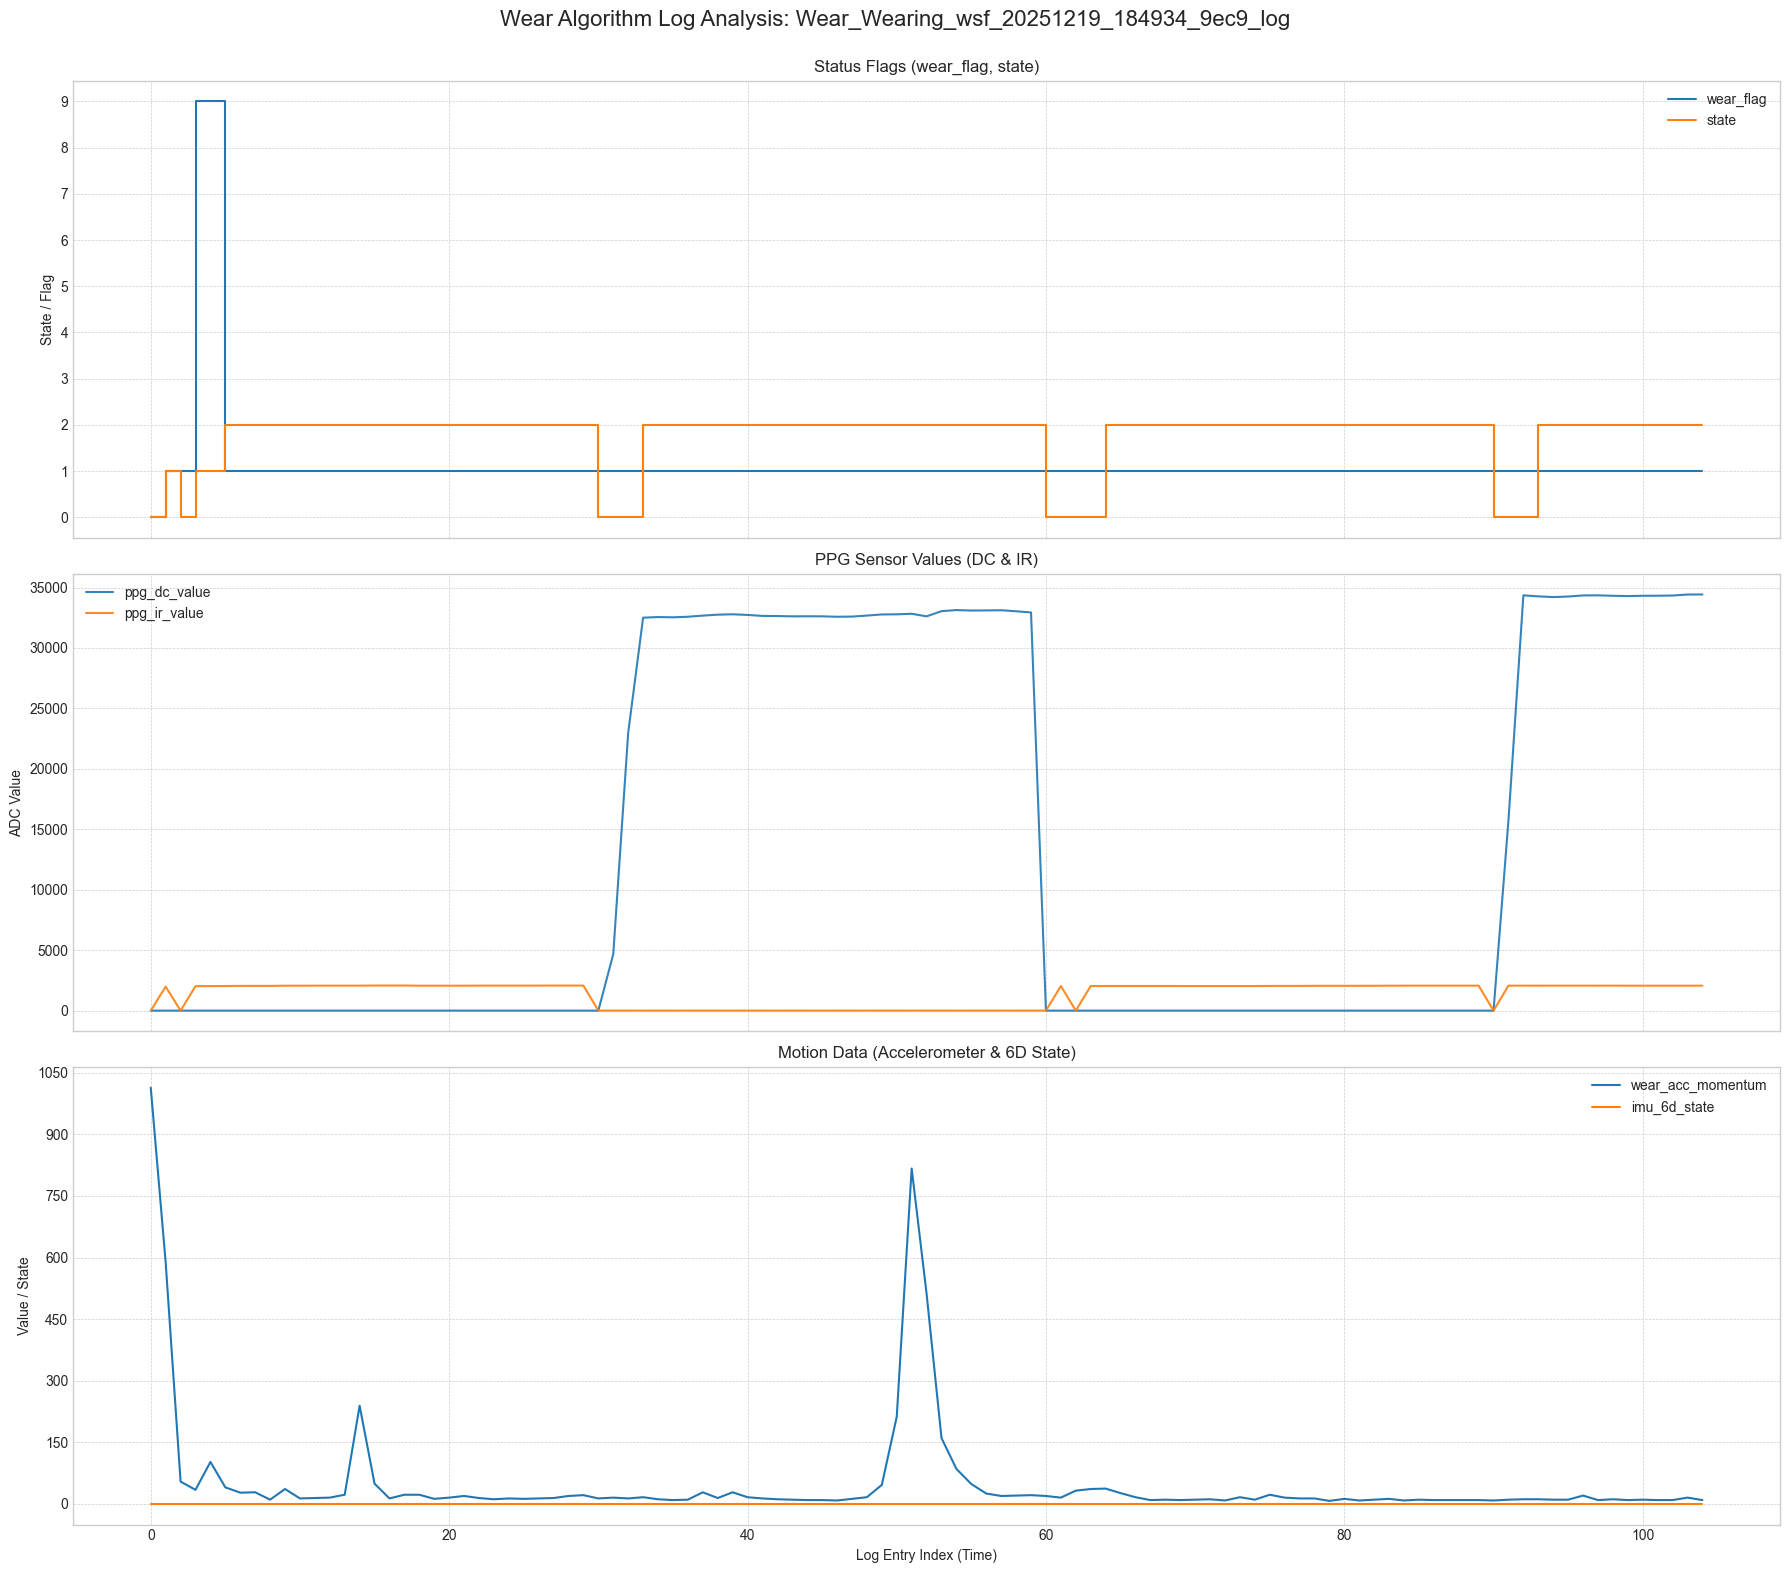

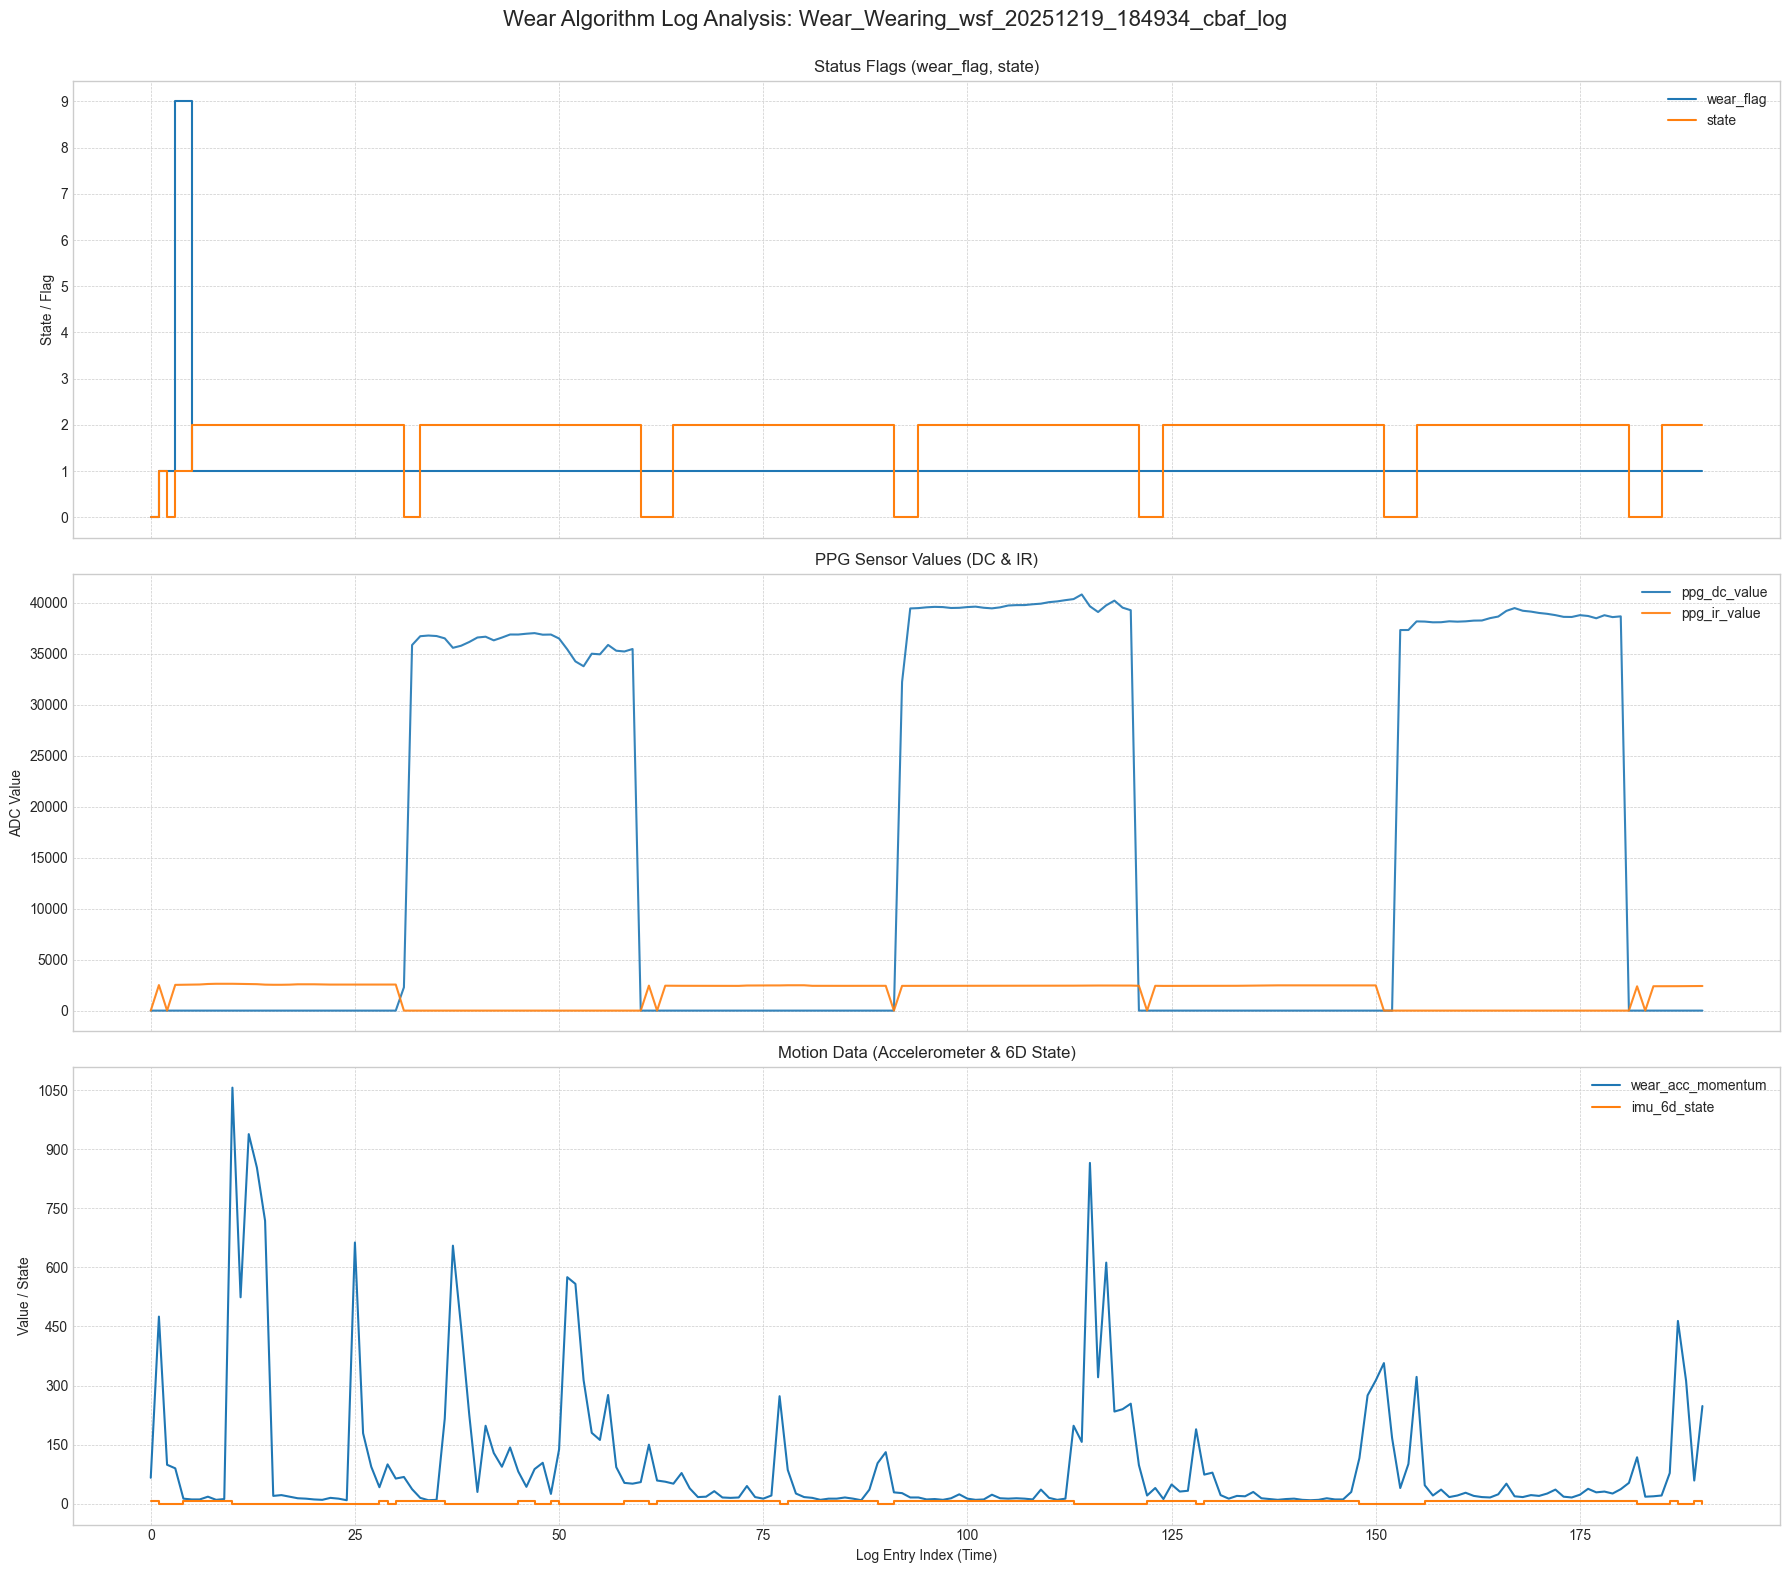

In [70]:
for filename in df_dict:
    df = df_dict[filename]
    # --- 2. 定义要绘制的参数组 ---
    params1 = ['wear_flag', 'state']
    params2 = ['ppg_dc_value', 'ppg_ir_value']
    params3 = ['wear_acc_momentum', 'imu_6d_state']

    # --- 3. 开始绘图 ---
    # 设置绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')

    # 创建子图,共享X轴
    fig, axes = plt.subplots(3, 1, figsize=(18, 16), sharex=True)
    fig.suptitle(f'Wear Algorithm Log Analysis: {filename}', fontsize=16)

    # --- 子图 1: 状态标志 ---
    ax1 = axes[0]
    for param in params1:
        # 使用 'steps-post' 样式可以更好地展示状态的阶跃变化
        ax1.plot(df.index, df[param], label=param, drawstyle='steps-post')
    ax1.set_title('Status Flags (wear_flag, state)')
    ax1.set_ylabel('State / Flag')
    # 强制Y轴为整数刻度,因为这些是状态值
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- 子图 2: PPG 信号值 ---
    ax2 = axes[1]
    for param in params2:
        ax2.plot(df.index, df[param], label=param, alpha=0.9)
    ax2.set_title('PPG Sensor Values (DC & IR)')
    ax2.set_ylabel('ADC Value')
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- 子图 3: 运动相关数据 ---
    ax3 = axes[2]
    for param in params3:
        # 对于状态值,也使用阶跃样式
        if 'state' in param:
            ax3.plot(df.index, df[param], label=param, drawstyle='steps-post')
        else:
            ax3.plot(df.index, df[param], label=param)
    ax3.set_title('Motion Data (Accelerometer & 6D State)')
    ax3.set_ylabel('Value / State')
    # 同样强制Y轴为整数刻度
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.legend()
    ax3.grid(True, which='both', linestyle='--', linewidth=0.5)

    # 为共享的X轴设置标签
    ax3.set_xlabel('Log Entry Index (Time)')

    # 调整布局以防止标题重叠
    plt.tight_layout(rect=(0, 0, 1, 0.98))

    # 显示图像
    plt.show()